# 0. Libraries and importing the data
In this case, we will only import the training data, as this step in the machine learning pipeline involves feature selection and hyperparameter tuning.

In [6]:
import pandas as pd
import numpy as np

# Graphical tools
import plotly.graph_objects as go
import plotly.express as px
import matplotlib.pyplot as plt

# Hyperparameter tuning and cross-validation
from sklearn.model_selection import RandomizedSearchCV

# For creating a pipeline
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from imblearn.pipeline import Pipeline as ImbPipeline

# For preprocessing
from sklearn.impute import SimpleImputer
from sklearn.impute import KNNImputer
from sklearn.preprocessing import StandardScaler

# Models
from sklearn.multiclass import OneVsRestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import GradientBoostingClassifier
from lightgbm import LGBMClassifier

# Classes for dealing with imbalanced datasets
from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import RandomOverSampler
from imblearn.over_sampling import SMOTE

# Extracting scores for all classes
from sklearn.metrics import classification_report

# Utilities
from scipy.stats import uniform
from scipy.stats import randint

## Preprocessed dataset version 1

In [7]:
dfv1 = pd.read_csv('2_preprocessed_datasets/v1_train.csv')
dfv1

,id,short_name,overall,potential,value_eur,wage_eur,height_cm,weight_kg,club_name,league_level,...,real_face_Yes,work_rate_High/High,work_rate_High/Low,work_rate_High/Medium,work_rate_Low/High,work_rate_Low/Low,work_rate_Low/Medium,work_rate_Medium/High,work_rate_Medium/Low,work_rate_Medium/Medium
0,216302,E. García,71,71,1400000.0,10000,176,73,Club Atlético de San Luis,1,...,False,False,False,False,False,False,False,True,False,False
1,237867,D. Cancola,65,71,1000000.0,2000,183,73,Ross County FC,1,...,False,False,False,False,False,False,False,False,False,True
2,253472,E. Kahl,65,77,1600000.0,2000,178,69,Aarhus GF,1,...,False,False,False,True,False,False,False,False,False,False
3,223994,S. Mugoša,72,72,2300000.0,5000,188,81,Incheon United FC,1,...,False,False,False,True,False,False,False,False,False,False
4,251635,A. Țigănașu,65,65,525000.0,3000,179,74,FC Botoşani,1,...,False,False,False,False,False,False,False,True,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6890,242007,C. Whelan,59,66,425000.0,2000,180,65,Carlisle United,4,...,False,False,False,False,False,False,False,False,False,True
6891,187961,Paulinho,83,83,28500000.0,61000,183,80,Al Ahli,1,...,True,True,False,False,False,False,False,False,False,False
6892,257234,Y. Hamache,70,80,3400000.0,6000,177,73,Boavista FC,1,...,False,False,False,True,False,False,False,False,False,False
6893,232511,S. Sasaki,71,71,1300000.0,7000,176,70,Sanfrecce Hiroshima,1,...,False,False,False,False,False,False,False,True,False,False


In [8]:
dfv1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6895 entries, 0 to 6894
Data columns (total 70 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   id                           6895 non-null   int64  
 1   short_name                   6895 non-null   object 
 2   overall                      6895 non-null   int64  
 3   potential                    6895 non-null   int64  
 4   value_eur                    6893 non-null   float64
 5   wage_eur                     6895 non-null   int64  
 6   height_cm                    6895 non-null   int64  
 7   weight_kg                    6895 non-null   int64  
 8   club_name                    6895 non-null   object 
 9   league_level                 6895 non-null   int64  
 10  club_jersey_number           6895 non-null   int64  
 11  club_contract_valid_until    6895 non-null   int64  
 12  nationality_name             6895 non-null   object 
 13  weak_foot         

In [5]:
# Count of null values per column
dfv1_na = dfv1.isnull().sum()

# Filter only columns with missing values
missing_values_tr = dfv1_na[dfv1_na > 0]

# Compute percentage of missing values
missing_values_percentage = (missing_values_tr / len(dfv1)) * 100

# Display the result
print("Columns with missing values:")
print(missing_values_tr)
print("\nPercentage of missing values:")
print(missing_values_percentage)

Columns with missing values:
value_eur               2
release_clause_eur    353
pace                  631
shooting              631
passing               631
dribbling             631
defending             631
physic                631
dtype: int64

Percentage of missing values:
value_eur             0.029007
release_clause_eur    5.119652
pace                  9.151559
shooting              9.151559
passing               9.151559
dribbling             9.151559
defending             9.151559
physic                9.151559
dtype: float64


## Lists of features

### Limited - feature selection based on EDA and preprocessing

All of the models below have been trained with the same features, where we discard those which we have seen that do not have much predictive power or that are highly correlated with other features (so that they are not expected to add much predictive power). The main reasons for this choice are the correlation matrix from the EDA, the boxplots from EDA and preprocessing and the heatmaps of deviations for categorical variables, which have been used here as **filtering methods**. Specifically, we have excluded:

**NUMERICAL VARIABLES**:
- *overall, potential*, as they do not have much predictive power.
- *wage_eur* is not expected to have a high predictive power. On the other hand, *release_clause_eur* has a linear correlation of 1 with *value_eur*, so the first is discarded.
- Attacking variables (2/5 removed):
    - *attacking_short_passing* is highly correlated with *attacking_crossing* (0.78), and the former has less predictive power than the latter. Thus, the first will not be included.
    - By the same reason, *attacking_volleys* (with a correlation of 0.89 with *attacking_finishing*) won't be included either.
- Skill variables (3/5 removed):
    - *skill_dribbling, skill_fk_accuracy* and *skill_ball_control* are removed due to their high correlation with *skill_curve* and because they have similar variability across positions.
    - *skill_long_passing* shows different variability, so it is kept.
- Movement variables (4/5 removed):
    - *movement_sprint_speed*, *movement_agility* and *movement_balance* are removed, due to their very high correlation with *movement_acceleration* and similar variability (though *movement_balance* has a correlation of "only" 0.71).
    - *movement_reactions* is also removed due to an apparently low predictive power.
- Power variables (3/5 removed):
    - *power_shot_power* is removed, due to the high correlation (0.8) and similar variability to *power_long_shots* (which seems to have higher variability).
    - *power_stamina* is also removed, since it does not have significant variability across non-GK positions.
    - *power_jumping* exhibits very similar variability across positions to *power_strenght*, but the latter seems more discriminatory. Therefore, the former is dropped.
- Mentality variables (3/5 removed):
    - *mentality_aggression* is highly correlated with *mentality_interceptions* and shows similar variability across positions (but with less apparent discriminatory power), so the first is dropped. 
    - *mentality_positioning* and *mentality_vision* are highly correlated with *mentality_penalties* and have similar variability across positions, so the first two are removed.
    - *mentality_composture* does not exhibit significant variability, so it is removed.
- Defending features (2/3 removed): all defending features are very highly correlated (> 0.9), so we only keep the one with the highest apparent discriminatory power, *defending_marking_awareness*.
- *pace*, *shooting*, *passing*, *dribbling* and *defending* are all kept.

**CATEGORICAL VARIABLES**:
- Excluded all features which are not expected to have a high predictive power: *club_contract_valid_until*, *league_level*, *club_jersey_number*, *short_name*, *club_name*, *nationality_name*, *league_country*, *real_face*.
- It is also important to remember to drop one dummy for KNN and logistic regression (but it is better to keep it for the decision tree).

In [9]:
# List of numerical features (22 in total)
numerical_features = [
    'height_cm', 'weight_kg',
    'attacking_crossing', 'attacking_finishing', 'attacking_heading_accuracy',
    'skill_curve', 'skill_long_passing','movement_acceleration', 'power_strength', 'power_long_shots',
    'mentality_interceptions', 'mentality_penalties', 'defending_marking_awareness', 
    'value_eur', 'pace', 'shooting', 'passing', 'dribbling', 'defending', 
    'physic', 'age', 'height_weight_ratio'
]

# List of categorical ordinal features (3 in total)
categorical_ordinal_features = [
    'weak_foot', 'skill_moves', 'international_reputation'
]

# List of categorical nominal features (11 in total)
categorical_nominal_features_all_dummies = [
    'preferred_foot_Right',	
    'preferred_foot_Left', 'work_rate_High/High', 'work_rate_High/Low', 'work_rate_High/Medium',
    'work_rate_Low/High', 'work_rate_Low/Low', 'work_rate_Low/Medium',
    'work_rate_Medium/High', 'work_rate_Medium/Low',
    'work_rate_Medium/Medium'
]

# List of categorical nominal features (9 in total)
categorical_nominal_features = [
    'preferred_foot_Right',	'work_rate_High/Low', 'work_rate_High/Medium',
    'work_rate_Low/High', 'work_rate_Low/Low', 'work_rate_Low/Medium',
    'work_rate_Medium/High', 'work_rate_Medium/Low',
    'work_rate_Medium/Medium'
]

# Complete list of categorical features (with all dummies, for decision trees) (36 features)
categorical_features_all_dummies = categorical_nominal_features_all_dummies + categorical_ordinal_features

# Complete list of categorical features (with k-1 dummies, for KNN and logistic regresion) (34 features)
categorical_features = categorical_nominal_features + categorical_ordinal_features

### Extended
Now, we keep all of the available features (except those that have not been preprocessed yet). Below, we only exclude:
- Excluded all features which are not expected to have a high predictive power: *club_contract_valid_until*, *short_name*, *club_name*, *nationality_name*, *league_country*, *real_face*.
- It is also important to remember to drop one dummy for KNN and logistic regression (but it is better to keep it for the decision tree).

In [10]:
# List of numerical features
numerical_features_ext = [
    'overall', 'potential', 'wage_eur', 'height_cm', 'weight_kg',
    'attacking_crossing', 'attacking_finishing', 'attacking_heading_accuracy', 'attacking_short_passing', 'attacking_volleys',
    'skill_dribbling', 'skill_curve', 'skill_fk_accuracy', 'skill_long_passing', 'skill_ball_control',
    'movement_acceleration', 'movement_sprint_speed', 'movement_agility', 'movement_reactions', 'movement_balance',
    'power_shot_power', 'power_jumping', 'power_stamina', 'power_strength', 'power_long_shots',
    'mentality_aggression', 'mentality_interceptions', 'mentality_positioning', 'mentality_vision', 'mentality_penalties', 'mentality_composure',
    'defending_marking_awareness', 'defending_standing_tackle', 'defending_sliding_tackle',
    'value_eur', 'release_clause_eur', 'pace', 'shooting', 'passing', 'dribbling', 'defending', 
    'physic', 'age', 'height_weight_ratio'
]

# List of categorical ordinal features 
categorical_ordinal_features_ext = [
    'league_level', 'weak_foot', 'skill_moves', 'international_reputation'
]

# List of categorical nominal features
categorical_nominal_features_ext_all_dummies = [
    'club_jersey_number', 'preferred_foot_Right',	
    'preferred_foot_Left',
    'work_rate_High/High', 'work_rate_High/Low', 'work_rate_High/Medium',
    'work_rate_Low/High', 'work_rate_Low/Low', 'work_rate_Low/Medium',
    'work_rate_Medium/High', 'work_rate_Medium/Low',
    'work_rate_Medium/Medium',
]

categorical_nominal_features_ext = [
    'club_jersey_number',
    'preferred_foot_Left',
    'work_rate_High/Low', 'work_rate_High/Medium',
    'work_rate_Low/High', 'work_rate_Low/Low', 'work_rate_Low/Medium',
    'work_rate_Medium/High', 'work_rate_Medium/Low',
    'work_rate_Medium/Medium',
]


# Complete list of categorical features
categorical_features_all_dummies_ext = categorical_nominal_features_ext_all_dummies + categorical_ordinal_features_ext
categorical_features_ext = categorical_nominal_features_ext + categorical_ordinal_features_ext

## Preliminary considerations: class imbalance
First of all, for evaluating the model it is worth noticing, again, that the dataset is highly imbalanced. The plots below show this characteristic of the dataset, where the first plot shows the relative frequencies of the positions (labels) with all of the possible positions and the second one shows the relative frequencies once we take out from the dataset goalkeepers (which will not be included in the model training, as it is possible to make a perfect prediction for that class *GK* with any of the variables *pace, shooting, passing, dribbling, defending* or *physic*, where missing values here correspond to goalkeepers).

### Imbalancing in the training dataset

In [20]:
# We save the relative frequencies of the 'position_grouped' column
relative_freq = dfv1['position_grouped'].value_counts(normalize=True).reset_index()

# We change the naming of the columns
relative_freq.columns = ['Position', 'Relative Frequency']

# Create a bar plot with Plotly
fig = px.bar(relative_freq, x='Position', y='Relative Frequency',
                title=f'Relative Frequency Barplot of the variable Position')

# Show the plot
fig.show()

In [21]:
# Now, we leave out the goalkeeper class
dfv1_nogk = dfv1[dfv1['position'] != 'GK']

# We save the relative frequencies of the 'position_grouped' column
relative_freq = dfv1_nogk['position_grouped'].value_counts(normalize=True).reset_index()

# We change the naming of the columns
relative_freq.columns = ['Position', 'Relative Frequency']

# Create a bar plot with Plotly
fig = px.bar(relative_freq, x='Position', y='Relative Frequency',
                title=f'Relative Frequency Barplot of the variable Position (leaving out goalkeepers)')

# Show the plot
fig.show()

In [34]:
# Count of null values per column
dfv1_nogk_na = dfv1_nogk.isnull().sum()

# Filter only columns with missing values
missing_values_tr = dfv1_nogk_na[dfv1_nogk_na > 0]

# Compute percentage of missing values
missing_values_percentage = (missing_values_tr / len(dfv1_nogk)) * 100

# Display the result
print("Columns with missing values:")
print(missing_values_tr)
print("\nPercentage of missing values:")
print(missing_values_percentage)

Columns with missing values:
value_eur               2
release_clause_eur    320
dtype: int64

Percentage of missing values:
value_eur             0.031928
release_clause_eur    5.108557
dtype: float64


### Insights

It can be observed that there are some classes that are highly overrepresented (especially LCB and RCB, which add up to 20% of the observations in the training dataset). In this context, then, some considerations must be made for the training, evaluation and prediction with this type of dataset:
- **Metric trap**: "Relying on simplistic metrics like accuracy_score can lead to misleading results. In datasets where classes are highly imbalanced, if a classifier consistently predicts the most prevalent class without considering any feature analysis, it can achieve a high accuracy rate [or any other performance measure] that is clearly deceptive."
- **Solutions for addressing the problem of imbalanced datasets**:
    - *Possible solution to metric trap: confusion matrix*. Given that we have to predict for different classes, maybe it would also be possible to compute the performance metric (such as the F1-score) for each position (or groups of positions), in order to have a more complete picture of the predictive power of the model.
    - *Resampling methodologies*. Mainly, oversampling the underrepresented classes and/or undersampling the majority classes through random resampling ("often with replacement"). See application in notebook 9 from class. Limitations:
        - "Over-sampling, for instance, can lead to overfitting when the minority class is duplicated indiscriminately."
        - "Under-sampling, which involves randomly removing records from the majority class, can result in information loss."
        - Alternative: SMOTE (Synthetic Minority Over-Sampling Technique). "It helps balance class distribution and reduce the impact of class imbalance on classification models." The limitation, of course, is that synthetic observations may not be accurate representations of their real counterparts. See section 1.3.2. of the notebook 9 from class.
- Finally, the models that are implemented below should apply **multiclass algorithms** (as, in this case, we do not have a binary classification problem). 

## Utilities

Below, we create a function which graphs the relative frequency of each position together with the F1-score obtained for each position with the best hyperparameters, which is found in the output of the "General training function" `df_combined_report`.

In [5]:
def graph_f1_per_position(df_train: pd.DataFrame, df_report: pd.DataFrame):

    # Relative frequencies
    ## We save the relative frequencies of the 'position_grouped' column
    relative_freq = df_train['position_grouped'].value_counts(normalize=True).reset_index()
    ## We change the naming of the columns
    relative_freq.columns = ['Position', 'Relative Frequency']

    # We save the f1-scores for the different positions
    ## We transpose the data frame and keep only the position indexes
    scores_per_position = df_report.T.iloc[0:-3]
    ## Extract positions (index) and F1-scores
    extracted_scores_position = scores_per_position.reset_index()[['index', 'f1-score']]
    ## Rename columns for clarity
    extracted_scores_position.columns = ['Position', 'F1 Score']

    # We join the relative frequency column on the extracted_scores data frame
    freq_scores = pd.merge(relative_freq, extracted_scores_position, on = 'Position')

    # Data for plotting
    positions = freq_scores['Position']
    f1_scores = freq_scores['F1 Score']
    relative_freqs = freq_scores['Relative Frequency']

    # Bar width and position
    bar_width = 0.4
    x = np.arange(len(positions))  # the label locations

    # Create the figure and axes
    fig, ax1 = plt.subplots(figsize=(20, 6))

    # Plot F1 Scores (left y-axis)
    bars1 = ax1.bar(x - bar_width / 2, f1_scores, bar_width, label='F1 Score', color='darkred')
    ax1.set_xlabel('Position')
    ax1.set_ylabel('F1 Score', color='darkred')
    ax1.tick_params(axis='y', labelcolor='darkred')
    ax1.set_xticks(x)
    ax1.set_xticklabels(positions, rotation=45, ha='right')

    # Create a secondary y-axis for Relative Frequency
    ax2 = ax1.twinx()
    bars2 = ax2.bar(x + bar_width / 2, relative_freqs, bar_width, label='Relative Frequency', color='steelblue')
    ax2.set_ylabel('Relative Frequency', color='steelblue')
    ax2.tick_params(axis='y', labelcolor='steelblue')

    # Add legend
    fig.legend(loc="upper center", bbox_to_anchor=(0.5, 1.05), ncol=2)

    # Adjust layout
    plt.title('F1 Scores and Relative Frequencies by Position')
    fig.tight_layout()

    # Show plot
    plt.show()

# 3. Feature and model selection and evaluation
Things to do in this section:
1. **Split** the data.
2. Impute **missing values** (if there is no listwise deletion).
3. Clean **outliers** (imputation or deletion).
4. **Standardization** of numerical variables (needed by KNN and for feature selection with logistic regression). Apply same standardization to validation data. No further transformations will be needed if categorical variables have been OHE or encoded in some other way.
5. Deal with **class imbalancing** for the training data (from `imblearn` - `over_sampling`, `under_sampling`, import `RandomUnderSampler`, `RandomOverSampler` and `SMOTE`).
6. **Hyperparameter tuning** (grid search or randomized search - `RandomizedSearchCV`).
7. Evaluate model through **cross-validation** (considering class imbalancing, stratified cross-validation is probably the best option).
8. Rank models with **evaluation metrics** (mainly: precision, recall, F1-score and AUC).
9. After finding the best-performing model (in this case, guided by the best F1-score), train the best model with the whole training dataset and the optimal hyperparameters.

How and when to apply resampling methodologies:
- Resampling methodologies should be applied after the train-validation split.
- Explanation:
    - Avoid information leakage: Resampling before splitting can cause synthetic data (oversampling) or missing data (undersampling) from the same original observations to appear in both train and validation sets. This results in overly optimistic validation performance.
    - True model evaluation: Resampling alters the class distribution, which should only affect the training data. The validation set should reflect the original distribution for an accurate evaluation of how the model would perform in the real world.
- Process:
    - Split the data into training and validation sets.
    - Preprocessing and feature engineering (so cleaning missing values, outliers and standardizing come BEFORE the application of resampling techniques, which can be affected if these transformations are not applied before). Concretely, the application of SMOTE would be biased if numerical features are not scaled beforehand.
    - Apply resampling techniques (oversampling, undersampling, or SMOTE) only on the training set (as a reference, see https://imbalanced-learn.org/stable/common_pitfalls.html).
    - Train the model on the resampled training set.
    - Evaluate the model on the original, untouched validation set.

Stratified cross-validation and resampling. Does it make sense to apply both of them?
- Without Resampling: Stratified cross-validation is ideal for imbalanced datasets because it ensures that each fold maintains the same class distribution as the original dataset.
- With Resampling: Stratification is less relevant because the class distribution in the training folds will be altered by resampling. However, you can still use stratified cross-validation on the unresampled validation set to evaluate the model. The goal here is to maintain the real-world class distribution in the validation set while resampling the training data within each fold.
- Suggested Strategy:
    - Use stratified splits for train-validation splitting.
    - Apply resampling within the training folds during each iteration of cross-validation.

## Baseline models
Below, we train and evaluate some baseline models, with and without resampling methodologies, in order to get an initial grasp of which model may have a higher predictive power and whether dealing with class imbalancing is worth the effort or not considering the performance metric that matters the most in this case (the F1-score).

In the models below, we:
1. **Split** the data.
2. Impute **missing values** with a simple imputer (median).
3. Don't do anything to **outliers**.
4. **Standardization** numerical variables for KNN and logistic regression. Apply same standardization to validation data.
5. (Not applied for the first baseline models, applied in the second) Deal with **class imbalancing** for the training data (from `imblearn` - `over_sampling`, `under_sampling`, import `RandomUnderSampler`, `RandomOverSampler` and `SMOTE`).
6. **Hyperparameter tuning** (randomized search - `RandomizedSearchCV`).
7. Evaluate model through **stratified cross-validation**.
8. Rank models with **evaluation metrics** (mainly: F1-score).

### General training function

In [ ]:
def baseline_models(
        df: pd.DataFrame, numerical_features: list[str], categorical_features: list[str], 
        target: str, model, ada_boost: bool = False, n_hyper_comb: int = 10, num_imputer: str = "median",
        goalkeeper_label: str = "GK", refit_score: str = 'f1_micro', resampling_method: str = 'none'
):
    
    """
    Function to evaluate baseline machine learning models for a classification task, 
    with hyperparameter tuning using RandomizedSearchCV. It preprocesses numerical and 
    categorical features, performs model fitting, and evaluates performance on the entire 
    dataset. Goalkeeper (GK) players are handled separately with special assumptions based 
    on the missing 'pace' feature. Additionally, it supports handling of class imbalance 
    through various resampling methods (oversampling, undersampling, SMOTE).

    Parameters:
    -----------
    df : pd.DataFrame
        The input dataset containing both numerical and categorical features as well as the target variable.
        
    numerical_features : list[str]
        List of column names representing numerical features in the dataset.

    categorical_features : list[str]
        List of column names representing categorical features in the dataset.
        
    target : str
        The name of the target variable (i.e., the variable to be predicted).
    
    model : class
        The model class to be used for training and evaluation (LogisticRegression, KNeighborsClassifier,
        DecisionTreeClassifier, RandomForestClassifier, GradientBoostingClassifier, LGBMClassifier).
    
    ada_boost : bool, default = False
        Implement adaptive boosting (can only be applied to decision trees).  

    n_hyper_comb : int, default=10
        The number of hyperparameter combinations to sample for RandomizedSearchCV.
        
    num_imputer : str, default="median"
        The strategy to use for imputing missing values in numerical features (e.g., "mean", "median").
        
    goalkeeper_label : str, default="GK"
        The label to assign to goalkeepers (assumed to have missing 'pace' feature values).
    
    refit_score : str, default="f1_micro"
        Score based on which the RandomizedSearchCV selects the optimal hyperparameters.
        Allowed scores are: ('f1_weighted', 'f1_micro', 'f1_macro', 'roc_auc_ovr_weighted').
        
    resampling_method : str, default='none'
        Method used to address class imbalance:
        - 'oversample' for RandomOverSampler
        - 'undersample' for RandomUnderSampler
        - 'smote' for SMOTE (Synthetic Minority Over-sampling Technique)
        - 'none' for no resampling.

    Returns:
    --------
    df_combined_report : pd.DataFrame
        DataFrame containing the classification report with metrics for all classes, including goalkeepers.
        Metrics include F1 scores (weighted, micro, and macro), and ROC AUC score for each class.

    optimal_hyperparameters : dict
        A dictionary of the optimal hyperparameters found by RandomizedSearchCV.

    cv_best_scores : dict
        A dictionary of best cross-validation scores for the model. Includes:
        - 'f1_weighted': Weighted F1 score
        - 'f1_micro': Micro-average F1 score
        - 'f1_macro': Macro-average F1 score
        - 'roc_auc_weighted': Weighted ROC AUC score
    """

    ###########################################################################

    # First, we create the pipeline for preprocessing numerical and categorical transformers

    # For numerical variables, we do median imputation
    num_prepr = [
        ("imputer", SimpleImputer(strategy = num_imputer))
    ]

    # We add standardization for certain models that benefit from it
    if model == LogisticRegression or model == KNeighborsClassifier or resampling_method == 'smote':
        num_prepr.append(("standardize", StandardScaler()))

    # For categorical variables, for now, we don't do anything (pass through)
    cat_prepr = [
        ("passthrough", "passthrough")
    ]

    # Create the ColumnTransformer to apply different transformations to numerical
    # and categorical variables
    preprocessor = ColumnTransformer(
        transformers=[
            ('num', Pipeline(num_prepr), numerical_features),
            ('cat', Pipeline(cat_prepr), categorical_features),
        ]
    )

    # Create steps of the pipeline, which begins with the preprocessor. 
    steps = [('preprocessor', preprocessor)]

    ###########################################################################

    # Second, we add the resampling step based on the chosen method (resampling after 
    # preprocessing and feature engineering)
    if resampling_method == 'oversample':
        resampling = RandomOverSampler(sampling_strategy = 'auto', random_state=17)
    elif resampling_method == 'undersample':
        resampling = RandomUnderSampler(sampling_strategy = 'auto', random_state=17)
    elif resampling_method == 'smote':
        resampling = SMOTE(sampling_strategy = 'auto', random_state=17)
    elif resampling_method == 'none':
        resampling = None  # No resampling
    else:
        raise ValueError('Invalid resampling type. Insert resampling method "oversample", "undersample", "smote" or "none" for no resampling.')

    if resampling:
        steps.append(('resampling', resampling))

    ###########################################################################

    # Third, depending on the model that has been chosen, we append one model
    # or another, and define the set of hyperparameters accordingly

    # We check if the model is one of the allowed model classes
    allowed_models = (LogisticRegression, KNeighborsClassifier, DecisionTreeClassifier,
                      RandomForestClassifier, GradientBoostingClassifier, LGBMClassifier)

    # We consider the possibility of applying adaptive boosting to the chosen model

    if ada_boost == False:

        if model == LogisticRegression:
            steps.append(('logreg', 
                                    OneVsRestClassifier(model( # With OVR, we make each class a binary problem (one-versus-the-rest)
                                    fit_intercept = True,
                                    max_iter = 2000,
                                    penalty = 'l2', # Ridge regularization
                                    class_weight = None
                                    ))))
            distributions = {
            'logreg__estimator__C': uniform(loc=0.01, scale=10)
            }

        elif model == KNeighborsClassifier:
            steps.append(('knn', model()))
            distributions = {
            'knn__n_neighbors': randint(low = 1, high = 25),
            'knn__weights': ['uniform', 'distance']
            }
        
        elif model == DecisionTreeClassifier:
            steps.append(('dtc', 
                                    model(
                                    random_state = 17,
                                    class_weight = None
                                    )))
            distributions = {
            'dtc__max_depth': randint(low = 1, high = 100),
            'dtc__max_features': randint(low = 1, high = (len(df[numerical_features + categorical_features].columns))),
            'dtc__max_leaf_nodes': randint(low = 1, high = 5000),
            'dtc__min_samples_leaf': uniform(loc=0.001, scale=0.199),
            'dtc__min_samples_split': uniform(loc=0.001, scale=0.199),            
            }
        
        elif model == RandomForestClassifier:
            steps.append(('rfc', 
                                    model(
                                    n_estimators = 1000,
                                    random_state = 17,
                                    oob_score = False,
                                    class_weight = None,
                                    n_jobs = -1
                                    )))
            distributions = {
            'rfc__max_depth': randint(low = 1, high = 300),
            'rfc__max_features': randint(low = 1, high = (len(df[numerical_features + categorical_features].columns))),
            'rfc__max_leaf_nodes': randint(low = 1, high = 5000),
            'rfc__min_samples_leaf': uniform(loc=0.001, scale=0.199),
            'rfc__min_samples_split': uniform(loc=0.001, scale=0.199),
            }
        
        elif model == GradientBoostingClassifier:
            steps.append(('gbc', 
                        model(
                            loss = 'log_loss',
                            random_state=17
                        )))
            distributions = {
                'gbc__learning_rate': [0.1, 0.5, 1.0],
                'gbc__max_depth': randint(low = 1, high = 300),
                'gbc__max_features': randint(low = 1, high = (len(df[numerical_features + categorical_features].columns))),
                'gbc__max_leaf_nodes': randint(low = 1, high = 5000),
                'gbc__min_samples_leaf': uniform(loc=0.001, scale=0.199),
                'gbc__min_samples_split': uniform(loc=0.001, scale=0.199),
                'gbc__n_estimators': [50, 100, 500],
                'gbc__subsample': uniform(loc=0.7, scale=0.3) # Subsample ratio (proportion of training samples to be used for training each estimator)
            }

        elif model == LGBMClassifier:
            steps.append(('lgb',
                        model(
                            objective = 'multiclass',
                            n_estimators = 100, # Number of boosting iterations (since LightGBM uses decision trees as the learners, this can also be thought of as “number of trees”. Same as n_estimators)
                            max_depth = -1, # No limit max_depth (default), set to this value as LightGBM focuses on leaf-wise tree growth algorithm
                            subsample = 1.0,  # In each iteration, train with all the training instances (since we already do CV)
                            device_type = 'cpu', # Change this parameter if prefer CPU to run the algorithm over GPU (though, since the dataset is small, in this case CPU might perform better)
                            verbosity = -1 # We disable all the information except for fatal messages
                    )))
            distributions = {
                'lgb__boosting_type': ['gbdt', 'rf'], # 'gbdt': Gradient Boosting Decision Tree. For boosting with Random Forests: 'rf' instead.
                'lgb__feature_fraction': uniform(loc = 0.5, scale = 0.5), # LightGBM will randomly select a subset of features on each iteration (tree) if feature_fraction is smaller than 1.0. Speeds up training and deals with overfitting
                'lgb__learning_rate': [0.01, 0.15, 0.3], # Lower values (e.g., 0.01) often yield better performance but require more iterations.
                'lgb__min_child_samples': randint(low = 5, high = 30), # Higher values prevent overfitting by ensuring leaves have enough data.
                'lgb__min_split_gain': uniform(loc = 0.0, scale = 0.1), # Minimum loss reduction required to make a further partition on a leaf node of the tree.
                'lgb__num_leaves': [15, 31, 63, 127], # Larger values increase model complexity and the risk of overfitting.
                'lgb__reg_lambda': uniform(loc = 0.0, scale = 1.0) # Ridge regularization parameter (alpha, default is 0)
            }

        else:
            raise ValueError(f"Invalid model type. Allowed models are: {allowed_models}")
    
    else:

        if model == DecisionTreeClassifier:
            base_estimator = model(
                random_state = 17,
                class_weight = None
            )
            ada_boost = AdaBoostClassifier(
                estimator = base_estimator,
                algorithm = 'SAMME',
                random_state = 17
            )
            steps.append(('adaboost', ada_boost))
            distributions = {
            'adaboost__estimator__max_depth': randint(low = 1, high = 100),
            'adaboost__estimator__max_features': randint(low = 1, high = (len(df[numerical_features + categorical_features].columns))),
            'adaboost__estimator__max_leaf_nodes': randint(low = 1, high = 5000),
            'adaboost__estimator__min_samples_leaf': uniform(loc=0.001, scale=0.199),
            'adaboost__estimator__min_samples_split': uniform(loc=0.001, scale=0.199),
            'adaboost__learning_rate': [0.1, 0.5, 1.0],
            'adaboost__n_estimators': [50, 100, 500]
            }

        else:
            raise ValueError("Only Decision Trees are allowed for AdaBoost (Random Forests are not due to use of computing resources).")
    
    ###########################################################################

    # Fourth, we create the pipeline with the preprocessing, resampling and the model
    pipeline = ImbPipeline(steps) # We use Pipeline from imblearn instead of sklearn's

    ###########################################################################

    # Fifth, we split the dataset into goalkeepers and non-goalkeepers: those
    # with missing values in the "pace" variable are assumed to be GKs (which
    # is true according to what was found in the EDA)

    df_gk = df[df['pace'].isna()].copy()
    df_nongk = df[~df['pace'].isna()].copy()

    # We divide the data frames depending on the variables

    X_nongk = df_nongk[numerical_features + categorical_features]
    y_nongk = df_nongk[target]

    y_gk = df_gk[target]

    ###########################################################################

    # Sixth, we do the randomized search with the model (only with the data w/o GK)
    
    scoring_metrics = ['f1_weighted', 'f1_micro', 'f1_macro', 'roc_auc_ovr_weighted']

    # Raise an exception if the refit_score is not one of the scoring_metrics
    if refit_score not in scoring_metrics:
        raise ValueError(f"Invalid score for finding optimal hyperparameters. Allowed scores are: {scoring_metrics}")

    clf = RandomizedSearchCV(
        estimator = pipeline, 
        param_distributions = distributions,
        n_iter = n_hyper_comb, # Default is 10
        scoring = scoring_metrics,
        n_jobs = -1, # We use all available processors
        cv = 5, # Use 5 stratified cross-validation folds
        verbose = 1,
        refit = refit_score, # Refit an estimator using the best found parameters on the whole dataset with the best score found (by default, f1_weighted)
        random_state = 17, 
        error_score = np.nan, 
        return_train_score = False)

    search = clf.fit(X_nongk, y_nongk)

    ###########################################################################

    # Seventh, we save the main results from the search

    # Best scores obtained with best hyperparameters through stratified cross-val
    cv_best_scores = {
        'f1_weighted': search.cv_results_['mean_test_f1_weighted'][search.best_index_], # Like f1_macro, but weights the metrics by the number of instances in each class
        'f1_micro': search.cv_results_['mean_test_f1_micro'][search.best_index_], # Calculates metrics globally by counting total true positives, false negatives, and false positives
        'f1_macro': search.cv_results_['mean_test_f1_macro'][search.best_index_], # Calculates metrics for each class independently and averages them without considering class imbalance
        'roc_auc_ovr_weighted': search.cv_results_['mean_test_roc_auc_ovr_weighted'][search.best_index_]
    }

    # Best hyperparameters from the search
    optimal_hyperparameters = search.best_params_

    ###########################################################################

    # Eigth, we run the predictions training with the optimal hyperparameters 
    # the whole dataset (note that this can lead to misleading results with higher
    # evaluation metrics than what we would get with the test set, as the
    # prediction is made with the same training dataset; in any case it can be useful
    # for indicating the labels which are missclassified more often)

    # Predictions for non-goalkeepers
    y_pred_nongk = search.best_estimator_.predict(X_nongk)

    # Predictions for goalkeepers: all observations here are predicted as GK
    y_pred_gk = [goalkeeper_label] * len(df_gk)

    # Combine predictions into a single dataframe
    y_combined = pd.concat([y_nongk, y_gk], axis=0)
    y_pred_combined = pd.concat([pd.Series(y_pred_nongk), pd.Series(y_pred_gk)], axis=0, ignore_index = True)

    ###########################################################################

    # Ninth, we evaluate combined metrics (note that we set that metrics with warnings
    # will be set to 0, for instance if we get a precision = 0 for some class)
    combined_report_dict = classification_report(y_combined, y_pred_combined, output_dict = True, zero_division = 0)
    df_combined_report = pd.DataFrame(combined_report_dict)

    ###########################################################################

    # Tenth, we return the results (metrics for classes computed for the training
    # set), including the best hyperparameters found - note that the results from 
    # KNN in df_combined_report will be entirely misleading, as the prediction 
    # is made with the same training data (so in that case, we just consider the 
    # best parameters and best score from the randomized search)

    if model == KNeighborsClassifier:
        return optimal_hyperparameters, cv_best_scores
    else:
        return df_combined_report, optimal_hyperparameters, cv_best_scores

Useful documentation:
- Randomized Search: https://scikit-learn.org/1.5/modules/generated/sklearn.model_selection.RandomizedSearchCV.html
- Scoring: https://scikit-learn.org/1.5/modules/model_evaluation.html#scoring-parameter. See also different types of f1 scores in: https://scikit-learn.org/1.5/modules/generated/sklearn.metrics.f1_score.html#sklearn.metrics.f1_score
- Pipeline: 
    - sklearn pipeline: https://scikit-learn.org/1.5/modules/generated/sklearn.pipeline.Pipeline.html#sklearn.pipeline.Pipeline
    - imblearn pipeline: https://imbalanced-learn.org/stable/references/generated/imblearn.pipeline.Pipeline.html#imblearn.pipeline.Pipeline. This is the pipeline that has been used to integrate the preprocessing with the imbalancing classes from imblearn and the model fitting of sklearn, to guarantee compatibility and correct application of resampling techniques. In the function above:
        1. Resampling is applied to the training data (before fitting the model).
        2. Preprocessing (imputation, scaling, etc.) comes after resampling, and it should be applied to the training data after resampling and to the test data without resampling.
        3. Model fitting occurs after the data is both resampled and preprocessed.
- Models:
    - One vs rest classifier (for multiclass classification): https://scikit-learn.org/1.5/modules/generated/sklearn.multiclass.OneVsRestClassifier.html
    - Logistic Regression: https://scikit-learn.org/1.5/modules/generated/sklearn.linear_model.LogisticRegression.html#sklearn.linear_model.LogisticRegression
    - Decision trees in sklearn can handle directly multiclass classification: "DecisionTreeClassifier is capable of both binary (where the labels are [-1, 1]) classification and multiclass (where the labels are [0, …, K-1]) classification." (https://scikit-learn.org/1.5/modules/tree.html). Also, see https://scikit-learn.org/1.5/modules/generated/sklearn.tree.DecisionTreeClassifier.html
    - KNN Classifier: https://scikit-learn.org/1.5/modules/generated/sklearn.neighbors.KNeighborsClassifier.html
    - Boosting:
        - AdaBoostClassifier: https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.AdaBoostClassifier.html
        - GradientBoostingClassifier: https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.GradientBoostingClassifier.html#sklearn.ensemble.GradientBoostingClassifier. No need for standardization as it is based on decision trees.
        - LightGBM: https://lightgbm.readthedocs.io/en/stable/. No need for standardization as it is based on decision trees. Some interesting features:
            - It can work directly with categorical features w/o OHE (higher speed of training).
            - Parameters for LGBMClassifier: https://lightgbm.readthedocs.io/en/stable/pythonapi/lightgbm.LGBMClassifier.html#lightgbm.LGBMClassifier
            - Additional parameters: https://lightgbm.readthedocs.io/en/stable/Parameters.html
            - Tips for parameter-tuning: https://lightgbm.readthedocs.io/en/stable/Parameters-Tuning.html
- Dealing with class imbalancing: https://imbalanced-learn.org/stable/index.html. See [RandomOverSampler](https://imbalanced-learn.org/stable/references/generated/imblearn.over_sampling.RandomOverSampler.html), [RandomUnderSampler](https://imbalanced-learn.org/stable/references/generated/imblearn.under_sampling.RandomUnderSampler.html#randomundersampler) and [SMOTE](https://imbalanced-learn.org/stable/references/generated/imblearn.over_sampling.SMOTE.html).

### Logistic regression

#### A. No resampling (without considering class imbalance)

In [112]:
df_report_logreg, best_params_logreg, best_scores_logreg = baseline_models(
    df = dfv1, numerical_features = numerical_features, categorical_features = categorical_features, 
    model = LogisticRegression, target = 'position_grouped', n_hyper_comb = 100, num_imputer = "median",
    goalkeeper_label = "G_GK", refit_score = 'f1_weighted', resampling_method = 'none'
    )

Fitting 5 folds for each of 100 candidates, totalling 500 fits


In [113]:
df_report_logreg

,A_LF,A_LS,A_LW,A_RF,A_RS,A_RW,A_ST,D_CB,D_LB,D_LCB,...,M_CM,M_LCM,M_LDM,M_LM,M_RCM,M_RDM,M_RM,accuracy,macro avg,weighted avg
precision,0.500000,0.255814,0.342105,0.0,0.153846,0.486486,0.482890,1.000000,0.595645,0.654731,...,0.0,0.290146,0.280702,0.281013,0.291605,0.340000,0.286064,0.486584,0.394506,0.472359
recall,0.031250,0.054726,0.078313,0.0,0.009950,0.108434,0.890187,0.011976,0.827214,0.405705,...,0.0,0.375887,0.079602,0.300813,0.468085,0.084577,0.317073,0.486584,0.300357,0.486584
f1-score,0.058824,0.090164,0.127451,0.0,0.018692,0.177340,0.626130,0.023669,0.692586,0.500978,...,0.0,0.327497,0.124031,0.290576,0.359347,0.135458,0.300771,0.486584,0.276826,0.432296
support,32.000000,201.000000,166.000000,32.0,201.000000,166.000000,428.000000,167.000000,463.000000,631.000000,...,75.0,423.000000,201.000000,369.000000,423.000000,201.000000,369.000000,0.486584,6895.000000,6895.000000


Graphical representation of the f1 scores for each position:

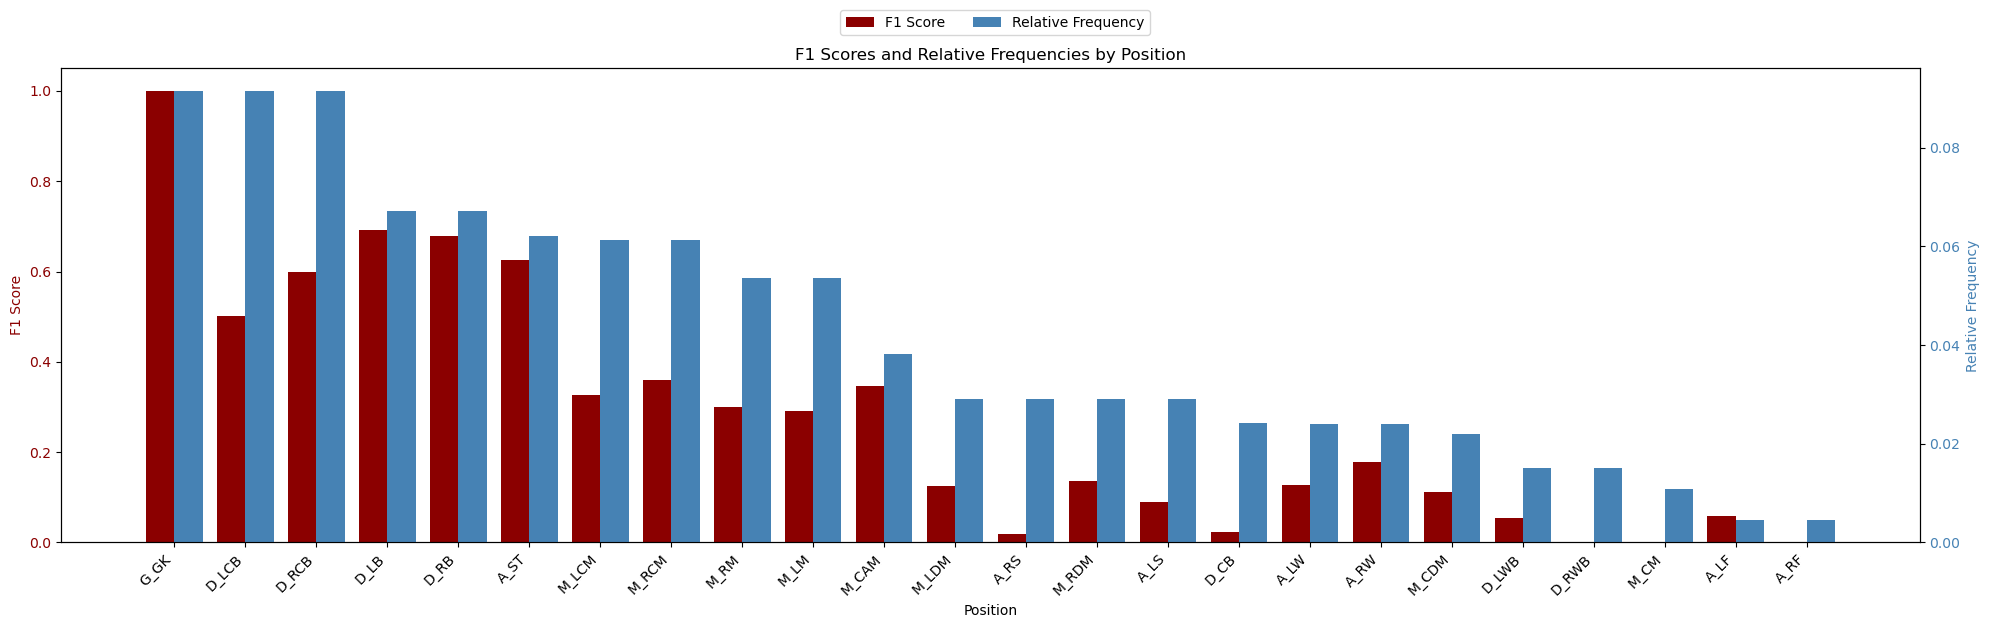

In [114]:
graph_f1_per_position(df_train = dfv1, df_report = df_report_logreg)

Insights from the graph:
- Clearly, the lower the representation of a position in the dataset, the worse the prediction! (in terms of the F1-score)
- Also, it can be noted that some positions with similar representation to others are much better predicted, for instance LB and RB are better predicted than LCB and RCB.

In [115]:
best_params_logreg

{'logreg__estimator__C': 8.88982434157199}

In [116]:
best_scores_logreg

{'f1_weighted': 0.3504338731270982,
 'f1_micro': 0.4085252263577,
 'f1_macro': 0.2209693029464408,
 'roc_auc_weighted': 0.9021076393679908}

#### B. Oversampling

In [ ]:
df_report_logreg_overs, best_params_logreg_overs, best_scores_logreg_overs = baseline_models(
    df = dfv1, numerical_features = numerical_features, categorical_features = categorical_features, 
    model = LogisticRegression, target = 'position_grouped', n_hyper_comb = 20, num_imputer = "median",
    goalkeeper_label = "G_GK", refit_score = 'f1_weighted', resampling_method = 'oversample'
    )

Fitting 5 folds for each of 20 candidates, totalling 100 fits


In [ ]:
df_report_logreg_overs

,A_LF,A_LS,A_LW,A_RF,A_RS,A_RW,A_ST,D_CB,D_LB,D_LCB,...,M_CM,M_LCM,M_LDM,M_LM,M_RCM,M_RDM,M_RM,accuracy,macro avg,weighted avg
precision,0.075949,0.251121,0.190722,0.042553,0.209184,0.241706,0.600575,0.190601,0.674938,0.733553,...,0.081633,0.288043,0.227723,0.355140,0.289474,0.198675,0.379562,0.402611,0.332255,0.468256
recall,0.562500,0.278607,0.222892,0.250000,0.203980,0.307229,0.488318,0.437126,0.587473,0.353407,...,0.320000,0.125296,0.114428,0.102981,0.130024,0.298507,0.140921,0.402611,0.362419,0.402611
f1-score,0.133829,0.264151,0.205556,0.072727,0.206549,0.270557,0.538660,0.265455,0.628176,0.477005,...,0.130081,0.174629,0.152318,0.159664,0.179445,0.238569,0.205534,0.402611,0.311338,0.411192
support,32.000000,201.000000,166.000000,32.000000,201.000000,166.000000,428.000000,167.000000,463.000000,631.000000,...,75.000000,423.000000,201.000000,369.000000,423.000000,201.000000,369.000000,0.402611,6895.000000,6895.000000


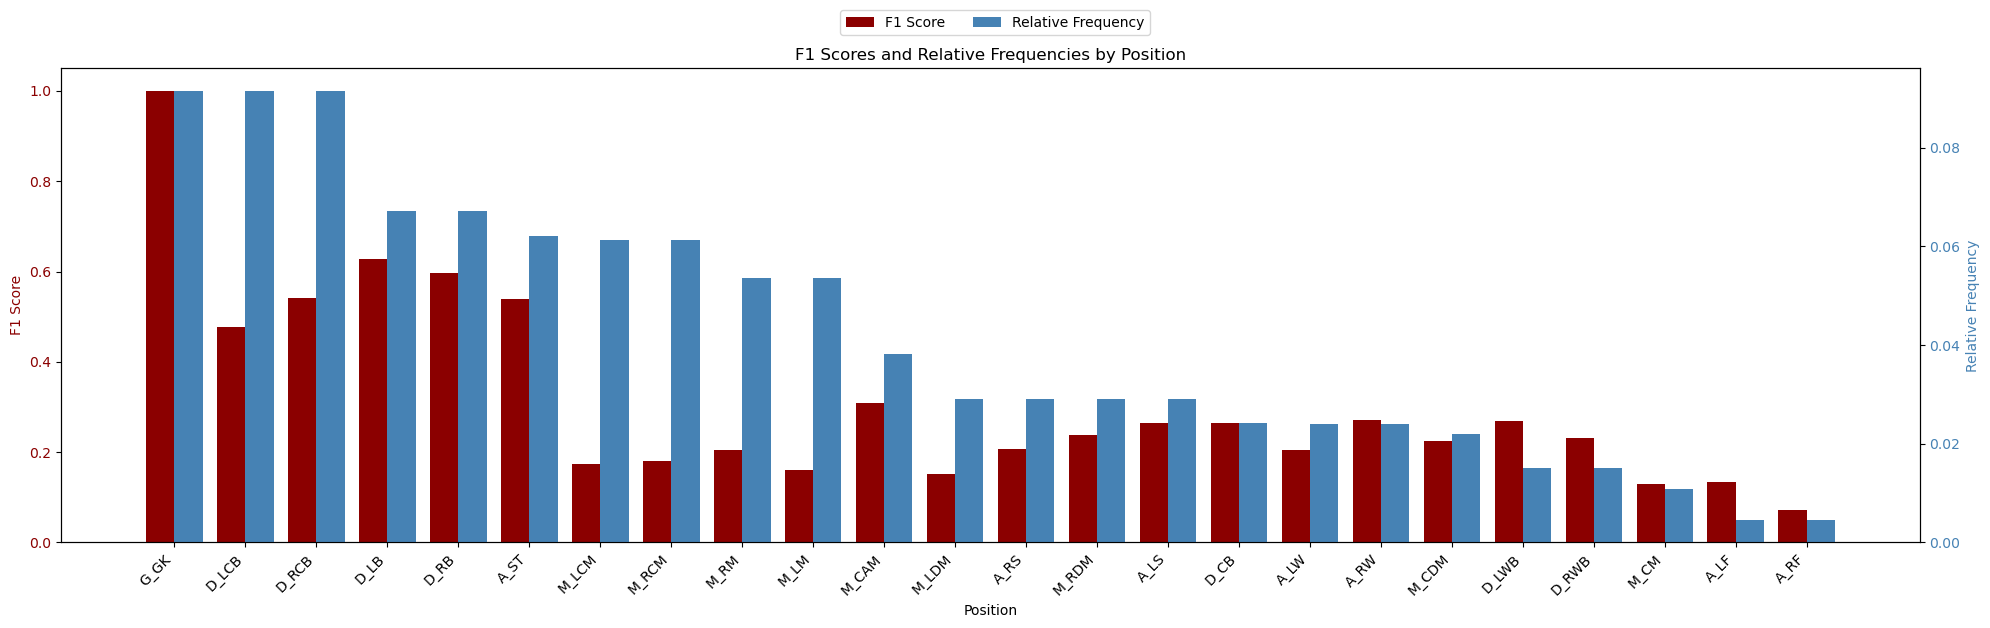

In [ ]:
graph_f1_per_position(df_train = dfv1, df_report = df_report_logreg_overs)

Note how, in comparison with the F1-scores without considering class imbalancing, the minority classes now have a (significantly, in some cases) better F1-score!

In [ ]:
best_params_logreg_overs

{'logreg__estimator__C': 0.4006291618886648}

In [ ]:
best_scores_logreg_overs

{'f1_weighted': 0.31506418164412275,
 'f1_micro': 0.301086338474562,
 'f1_macro': 0.23455711581287977,
 'roc_auc_weighted': 0.8987488011113788}

#### C. SMOTE

#### D. Undersampling

In [ ]:
df_report_logreg_under, best_params_logreg_under, best_scores_logreg_under = baseline_models(
    df = dfv1, numerical_features = numerical_features, categorical_features = categorical_features, 
    model = LogisticRegression, target = 'position_grouped', n_hyper_comb = 20, num_imputer = "median",
    goalkeeper_label = "G_GK", refit_score = 'f1_weighted', resampling_method = 'undersample'
    )

Fitting 5 folds for each of 20 candidates, totalling 100 fits


In [ ]:
df_report_logreg_under

,A_LF,A_LS,A_LW,A_RF,A_RS,A_RW,A_ST,D_CB,D_LB,D_LCB,...,M_CM,M_LCM,M_LDM,M_LM,M_RCM,M_RDM,M_RM,accuracy,macro avg,weighted avg
precision,0.103030,0.169811,0.155914,0.025862,0.191729,0.166090,0.575472,0.133094,0.597701,0.551181,...,0.083770,0.198980,0.135266,0.348624,0.218750,0.186813,0.235602,0.340682,0.281852,0.405740
recall,0.531250,0.179104,0.174699,0.093750,0.253731,0.289157,0.427570,0.443114,0.449244,0.332805,...,0.213333,0.092199,0.139303,0.102981,0.132388,0.169154,0.121951,0.340682,0.307335,0.340682
f1-score,0.172589,0.174334,0.164773,0.040541,0.218415,0.210989,0.490617,0.204703,0.512947,0.415020,...,0.120301,0.126010,0.137255,0.158996,0.164948,0.177546,0.160714,0.340682,0.264644,0.353448
support,32.000000,201.000000,166.000000,32.000000,201.000000,166.000000,428.000000,167.000000,463.000000,631.000000,...,75.000000,423.000000,201.000000,369.000000,423.000000,201.000000,369.000000,0.340682,6895.000000,6895.000000


In [ ]:
best_params_logreg_under

{'logreg__estimator__C': 0.6890035819129137}

In [ ]:
best_scores_logreg_under

{'f1_weighted': 0.2841787762316953,
 'f1_micro': 0.2705932598823526,
 'f1_macro': 0.2158155469629615,
 'roc_auc_weighted': 0.8684332524412028}

#### E. Extended number of features, no resampling

In [12]:
df_report_logreg_ext, best_params_logreg_ext, best_scores_logreg_ext = baseline_models(
    df = dfv1, numerical_features = numerical_features_ext, categorical_features = categorical_features_ext, 
    model = LogisticRegression, target = 'position_grouped', n_hyper_comb = 100, num_imputer = "median",
    goalkeeper_label = "G_GK", refit_score = 'f1_weighted', resampling_method = 'none'
    )

Fitting 5 folds for each of 100 candidates, totalling 500 fits


In [13]:
df_report_logreg_ext

,A_LF,A_LS,A_LW,A_RF,A_RS,A_RW,A_ST,D_CB,D_LB,D_LCB,...,M_CM,M_LCM,M_LDM,M_LM,M_RCM,M_RDM,M_RM,accuracy,macro avg,weighted avg
precision,0.428571,0.321429,0.351852,1.000000,0.366667,0.400000,0.509563,0.500000,0.640599,0.655738,...,0.166667,0.319066,0.416667,0.318302,0.328881,0.311688,0.338798,0.50979,0.460671,0.498719
recall,0.093750,0.134328,0.114458,0.031250,0.109453,0.168675,0.871495,0.017964,0.831533,0.443740,...,0.013333,0.387707,0.149254,0.325203,0.465721,0.119403,0.336043,0.50979,0.335287,0.509790
f1-score,0.153846,0.189474,0.172727,0.060606,0.168582,0.237288,0.643103,0.034682,0.723684,0.529301,...,0.024691,0.350053,0.219780,0.321716,0.385519,0.172662,0.337415,0.50979,0.328002,0.468332
support,32.000000,201.000000,166.000000,32.000000,201.000000,166.000000,428.000000,167.000000,463.000000,631.000000,...,75.000000,423.000000,201.000000,369.000000,423.000000,201.000000,369.000000,0.50979,6895.000000,6895.000000


In [14]:
best_params_logreg_ext

{'logreg__estimator__C': 8.88736351885637}

In [15]:
best_scores_logreg_ext

{'f1_weighted': 0.3655801648317382,
 'f1_micro': 0.4117182021933303,
 'f1_macro': 0.24078356366424963,
 'roc_auc_weighted': 0.9060559989617039}

#### F. No resampling, finding best f1-micro
It seems that the Kaggle competition is based on the F1-micro score instead of on the weighted F1-score, so we should optimize hyperparameters according to that.

In [8]:
df_report_logreg_v2, best_params_logreg_v2, best_scores_logreg_v2 = baseline_models(
    df = dfv1, numerical_features = numerical_features, categorical_features = categorical_features, 
    model = LogisticRegression, target = 'position_grouped', n_hyper_comb = 100, num_imputer = "median",
    goalkeeper_label = "G_GK", refit_score = 'f1_micro', resampling_method = 'none'
    )

Fitting 5 folds for each of 100 candidates, totalling 500 fits


In [9]:
df_report_logreg_v2

,A_LF,A_LS,A_LW,A_RF,A_RS,A_RW,A_ST,D_CB,D_LB,D_LCB,...,M_CM,M_LCM,M_LDM,M_LM,M_RCM,M_RDM,M_RM,accuracy,macro avg,weighted avg
precision,0.0,0.214286,0.227273,0.0,0.250000,0.416667,0.477301,1.000000,0.591185,0.662269,...,0.0,0.295539,0.272727,0.270396,0.269553,0.428571,0.282353,0.480783,0.348174,0.458541
recall,0.0,0.029851,0.030120,0.0,0.009950,0.030120,0.908879,0.005988,0.840173,0.397781,...,0.0,0.375887,0.044776,0.314363,0.456265,0.074627,0.325203,0.480783,0.288526,0.480783
f1-score,0.0,0.052402,0.053191,0.0,0.019139,0.056180,0.625905,0.011905,0.694023,0.497030,...,0.0,0.330905,0.076923,0.290727,0.338894,0.127119,0.302267,0.480783,0.255703,0.419533
support,32.0,201.000000,166.000000,32.0,201.000000,166.000000,428.000000,167.000000,463.000000,631.000000,...,75.0,423.000000,201.000000,369.000000,423.000000,201.000000,369.000000,0.480783,6895.000000,6895.000000


In [10]:
best_params_logreg_v2

{'logreg__estimator__C': 0.1669619295094371}

In [11]:
best_scores_logreg_v2

{'f1_weighted': 0.3422679441240949,
 'f1_micro': 0.40900394962632813,
 'f1_macro': 0.20608435142822876,
 'roc_auc_weighted': 0.9049061544570997}

#### G. Oversampling, finding best F1-micro

In [33]:
df_report_logreg_over2, best_params_logreg_over2, best_scores_logreg_over2 = baseline_models(
    df = dfv1, numerical_features = numerical_features, categorical_features = categorical_features, 
    model = LogisticRegression, target = 'position_grouped', n_hyper_comb = 100, num_imputer = "median",
    goalkeeper_label = "G_GK", refit_score = 'f1_micro', resampling_method = 'oversample'
    )

Fitting 5 folds for each of 100 candidates, totalling 500 fits


In [34]:
df_report_logreg_over2

,A_LF,A_LS,A_LW,A_RF,A_RS,A_RW,A_ST,D_CB,D_LB,D_LCB,...,M_CM,M_LCM,M_LDM,M_LM,M_RCM,M_RDM,M_RM,accuracy,macro avg,weighted avg
precision,0.074689,0.252336,0.197970,0.038043,0.204188,0.224299,0.595628,0.192802,0.670823,0.733553,...,0.078767,0.293478,0.237113,0.340000,0.279570,0.192691,0.382353,0.402321,0.330835,0.466734
recall,0.562500,0.268657,0.234940,0.218750,0.194030,0.289157,0.509346,0.449102,0.580994,0.353407,...,0.306667,0.127660,0.114428,0.092141,0.122931,0.288557,0.140921,0.402321,0.360125,0.402321
f1-score,0.131868,0.260241,0.214876,0.064815,0.198980,0.252632,0.549118,0.269784,0.622685,0.477005,...,0.125341,0.177924,0.154362,0.144989,0.170772,0.231076,0.205941,0.402321,0.309803,0.410185
support,32.000000,201.000000,166.000000,32.000000,201.000000,166.000000,428.000000,167.000000,463.000000,631.000000,...,75.000000,423.000000,201.000000,369.000000,423.000000,201.000000,369.000000,0.402321,6895.000000,6895.000000


In [35]:
best_params_logreg_over2

{'logreg__estimator__C': 0.1669619295094371}

In [36]:
best_scores_logreg_over2

{'f1_weighted': 0.31661269322398333,
 'f1_micro': 0.30364071914306623,
 'f1_macro': 0.2352599215200819,
 'roc_auc_weighted': 0.8996750927992945}

#### H. Undersampling, finding best F1-micro

In [37]:
df_report_logreg_under2, best_params_logreg_under2, best_scores_logreg_under2 = baseline_models(
    df = dfv1, numerical_features = numerical_features, categorical_features = categorical_features, 
    model = LogisticRegression, target = 'position_grouped', n_hyper_comb = 100, num_imputer = "median",
    goalkeeper_label = "G_GK", refit_score = 'f1_micro', resampling_method = 'undersample'
    )

Fitting 5 folds for each of 100 candidates, totalling 500 fits


In [38]:
df_report_logreg_under2

,A_LF,A_LS,A_LW,A_RF,A_RS,A_RW,A_ST,D_CB,D_LB,D_LCB,...,M_CM,M_LCM,M_LDM,M_LM,M_RCM,M_RDM,M_RM,accuracy,macro avg,weighted avg
precision,0.098837,0.165746,0.142180,0.036697,0.182836,0.153025,0.572581,0.147458,0.604520,0.549072,...,0.082927,0.186667,0.137566,0.410256,0.248804,0.168675,0.246988,0.341987,0.284438,0.409985
recall,0.531250,0.149254,0.180723,0.125000,0.243781,0.259036,0.497664,0.520958,0.462203,0.328051,...,0.226667,0.099291,0.129353,0.086721,0.122931,0.139303,0.111111,0.341987,0.309001,0.341987
f1-score,0.166667,0.157068,0.159151,0.056738,0.208955,0.192394,0.532500,0.229855,0.523868,0.410714,...,0.121429,0.129630,0.133333,0.143177,0.164557,0.152589,0.153271,0.341987,0.263659,0.352898
support,32.000000,201.000000,166.000000,32.000000,201.000000,166.000000,428.000000,167.000000,463.000000,631.000000,...,75.000000,423.000000,201.000000,369.000000,423.000000,201.000000,369.000000,0.341987,6895.000000,6895.000000


In [39]:
best_params_logreg_under2

{'logreg__estimator__C': 0.1669619295094371}

In [40]:
best_scores_logreg_under2

{'f1_weighted': 0.2825348014096734,
 'f1_micro': 0.2728266218583387,
 'f1_macro': 0.21610356151945803,
 'roc_auc_weighted': 0.8770631151239353}

### K-Nearest Neighbors

#### A. No resampling (without considering class imbalance)

In [109]:
best_params_knn, best_scores_knn = baseline_models(
    df = dfv1, numerical_features = numerical_features, categorical_features = categorical_features, 
    model = KNeighborsClassifier, target = 'position_grouped', n_hyper_comb = 100, num_imputer = "median",
    goalkeeper_label = "G_GK", refit_score = 'f1_weighted', resampling_method = 'none'
    )

Fitting 5 folds for each of 100 candidates, totalling 500 fits


In [110]:
best_params_knn

{'knn__n_neighbors': 21, 'knn__weights': 'distance'}

In [111]:
best_scores_knn

{'f1_weighted': 0.3063081511690249,
 'f1_micro': 0.3502521743343133,
 'f1_macro': 0.19344830596840346,
 'roc_auc_weighted': 0.8553003669377753}

### Decision Tree

#### A. No resampling (without considering class imbalance)

In [ ]:
df_report_dt, best_params_dt, best_scores_dt = baseline_models(
    df = dfv1, numerical_features = numerical_features, categorical_features = categorical_features_all_dummies, 
    model = DecisionTreeClassifier, target = 'position_grouped', n_hyper_comb = 100, num_imputer = "median",
    goalkeeper_label = "G_GK", refit_score = 'f1_weighted', resampling_method = 'none'
    )

Fitting 5 folds for each of 100 candidates, totalling 500 fits


In [14]:
df_report_dt

,A_LF,A_LS,A_LW,A_RF,A_RS,A_RW,A_ST,D_CB,D_LB,D_LCB,...,M_CM,M_LCM,M_LDM,M_LM,M_RCM,M_RDM,M_RM,accuracy,macro avg,weighted avg
precision,0.0,0.363095,0.275862,0.0,0.343750,0.212500,0.542714,0.0,0.570552,0.560060,...,0.0,0.337545,0.235669,0.327014,0.353635,0.245455,0.386423,0.498912,0.298748,0.439437
recall,0.0,0.303483,0.144578,0.0,0.164179,0.102410,0.757009,0.0,0.803456,0.591125,...,0.0,0.442080,0.184080,0.373984,0.425532,0.134328,0.401084,0.498912,0.317802,0.498912
f1-score,0.0,0.330623,0.189723,0.0,0.222222,0.138211,0.632195,0.0,0.667265,0.575173,...,0.0,0.382805,0.206704,0.348925,0.386266,0.173633,0.393617,0.498912,0.299714,0.459349
support,32.0,201.000000,166.000000,32.0,201.000000,166.000000,428.000000,167.0,463.000000,631.000000,...,75.0,423.000000,201.000000,369.000000,423.000000,201.000000,369.000000,0.498912,6895.000000,6895.000000


In [15]:
best_params_dt

{'dtc__class_weight': None,
 'dtc__max_depth': 40,
 'dtc__max_features': 24,
 'dtc__max_leaf_nodes': 1244,
 'dtc__min_samples_leaf': 0.0013015285199047416,
 'dtc__min_samples_split': 0.010912693744184222}

In [33]:
best_scores_dt

{'f1_weighted': 0.3014515619237356,
 'f1_micro': 0.33285444007863557,
 'f1_macro': 0.19733507108989157,
 'roc_auc_weighted': 0.8319108990985502}

#### B. Extended number of features (without resampling)

In [ ]:
df_report_dt_ext, best_params_dt_ext, best_scores_dt_ext = baseline_models(
    df = dfv1, numerical_features = numerical_features_ext, categorical_features = categorical_features_ext, 
    model = DecisionTreeClassifier, target = 'position_grouped', n_hyper_comb = 100, num_imputer = "median",
    goalkeeper_label = "G_GK", refit_score = 'f1_weighted', resampling_method = 'none'
    )

Fitting 5 folds for each of 100 candidates, totalling 500 fits


In [ ]:
df_report_dt_ext

,A_LF,A_LS,A_LW,A_RF,A_RS,A_RW,A_ST,D_CB,D_LB,D_LCB,...,M_CM,M_LCM,M_LDM,M_LM,M_RCM,M_RDM,M_RM,accuracy,macro avg,weighted avg
precision,0.0,0.0,0.0,0.0,0.0,0.0,0.497674,0.0,0.407972,0.572254,...,0.0,0.236559,0.0,0.230263,0.226607,0.0,0.188259,0.406091,0.181915,0.326516
recall,0.0,0.0,0.0,0.0,0.0,0.0,0.750000,0.0,0.751620,0.313788,...,0.0,0.104019,0.0,0.284553,0.475177,0.0,0.252033,0.406091,0.234804,0.406091
f1-score,0.0,0.0,0.0,0.0,0.0,0.0,0.598322,0.0,0.528875,0.405322,...,0.0,0.144499,0.0,0.254545,0.306870,0.0,0.215527,0.406091,0.194631,0.343600
support,32.0,201.0,166.0,32.0,201.0,166.0,428.000000,167.0,463.000000,631.000000,...,75.0,423.000000,201.0,369.000000,423.000000,201.0,369.000000,0.406091,6895.000000,6895.000000


In [ ]:
best_params_dt_ext

{'dtc__class_weight': None,
 'dtc__max_depth': 13,
 'dtc__max_features': 55,
 'dtc__max_leaf_nodes': 1000,
 'dtc__min_samples_leaf': 0.027908784118733383,
 'dtc__min_samples_split': 0.05608362352155855}

In [ ]:
best_scores_dt_ext

{'f1_weighted': 0.2651632261081637,
 'f1_micro': 0.3303018442638626,
 'f1_macro': 0.15280702015262904,
 'roc_auc_weighted': 0.8565792323601504}

#### C. No resampling, with adaptive boosting

In [ ]:
df_report_dt_adaboost, best_params_dt_adaboost, best_scores_dt_adaboost = baseline_models(
    df = dfv1, numerical_features = numerical_features, categorical_features = categorical_features_all_dummies, 
    target = 'position_grouped', model = DecisionTreeClassifier, ada_boost = True, n_hyper_comb = 100, num_imputer = "median",
    goalkeeper_label = "G_GK", refit_score = 'f1_micro', resampling_method = 'none'
    )

Fitting 5 folds for each of 100 candidates, totalling 500 fits


/home/pablo/miniconda3/envs/py312/lib/python3.12/site-packages/numpy/ma/core.py:2820: RuntimeWarning: invalid value encountered in cast
  _data = np.array(data, dtype=dtype, copy=copy,


In [7]:
df_report_dt_adaboost

,A_LF,A_LS,A_LW,A_RF,A_RS,A_RW,A_ST,D_CB,D_LB,D_LCB,...,M_CM,M_LCM,M_LDM,M_LM,M_RCM,M_RDM,M_RM,accuracy,macro avg,weighted avg
precision,0.0,0.155556,0.100000,0.0,0.243902,0.210526,0.478697,0.500000,0.541791,0.591579,...,0.0,0.278846,0.300000,0.248555,0.267652,0.235955,0.268585,0.462364,0.300379,0.417379
recall,0.0,0.034826,0.012048,0.0,0.049751,0.024096,0.892523,0.005988,0.784017,0.445325,...,0.0,0.342790,0.014925,0.349593,0.385343,0.104478,0.303523,0.462364,0.276446,0.462364
f1-score,0.0,0.056911,0.021505,0.0,0.082645,0.043243,0.623165,0.011834,0.640777,0.508137,...,0.0,0.307529,0.028436,0.290541,0.315891,0.144828,0.284987,0.462364,0.247230,0.407492
support,32.0,201.000000,166.000000,32.0,201.000000,166.000000,428.000000,167.000000,463.000000,631.000000,...,75.0,423.000000,201.000000,369.000000,423.000000,201.000000,369.000000,0.462364,6895.000000,6895.000000


In [8]:
best_params_dt_adaboost

{'adaboost__estimator__max_depth': 31,
 'adaboost__estimator__max_features': 10,
 'adaboost__estimator__max_leaf_nodes': 4945,
 'adaboost__estimator__min_samples_leaf': 0.033785596409893315,
 'adaboost__estimator__min_samples_split': 0.15685639533910706,
 'adaboost__learning_rate': 0.1,
 'adaboost__n_estimators': 100}

In [9]:
best_scores_dt_adaboost

{'f1_weighted': 0.3271805064468502,
 'f1_micro': 0.38378039669649067,
 'f1_macro': 0.1984955865804376,
 'roc_auc_weighted': 0.8900241148200992}

### Random Forest

#### A. No resampling (without considering class imbalance)

In [ ]:
df_report_rf, best_params_rf, best_scores_rf = baseline_models(
    df = dfv1, numerical_features = numerical_features, categorical_features = categorical_features_all_dummies, 
    model = RandomForestClassifier, target = 'position_grouped', n_hyper_comb = 100, num_imputer = "median",
    goalkeeper_label = "G_GK", refit_score = 'f1_weighted', resampling_method = 'none'
    )

Fitting 5 folds for each of 100 candidates, totalling 500 fits


In [71]:
df_report_rf

,A_LF,A_LS,A_LW,A_RF,A_RS,A_RW,A_ST,D_CB,D_LB,D_LCB,...,M_CM,M_LCM,M_LDM,M_LM,M_RCM,M_RDM,M_RM,accuracy,macro avg,weighted avg
precision,0.0,0.875000,0.750000,0.0,0.0,0.900000,0.461714,0.0,0.576696,0.716456,...,0.0,0.466535,0.888889,0.458904,0.389140,0.711538,0.409346,0.544162,0.452352,0.551023
recall,0.0,0.034826,0.018072,0.0,0.0,0.054217,0.943925,0.0,0.844492,0.448494,...,0.0,0.560284,0.039801,0.544715,0.609929,0.184080,0.593496,0.544162,0.334748,0.544162
f1-score,0.0,0.066986,0.035294,0.0,0.0,0.102273,0.620107,0.0,0.685364,0.551657,...,0.0,0.509130,0.076190,0.498141,0.475138,0.292490,0.484513,0.544162,0.298803,0.475156
support,32.0,201.000000,166.000000,32.0,201.0,166.000000,428.000000,167.0,463.000000,631.000000,...,75.0,423.000000,201.000000,369.000000,423.000000,201.000000,369.000000,0.544162,6895.000000,6895.000000


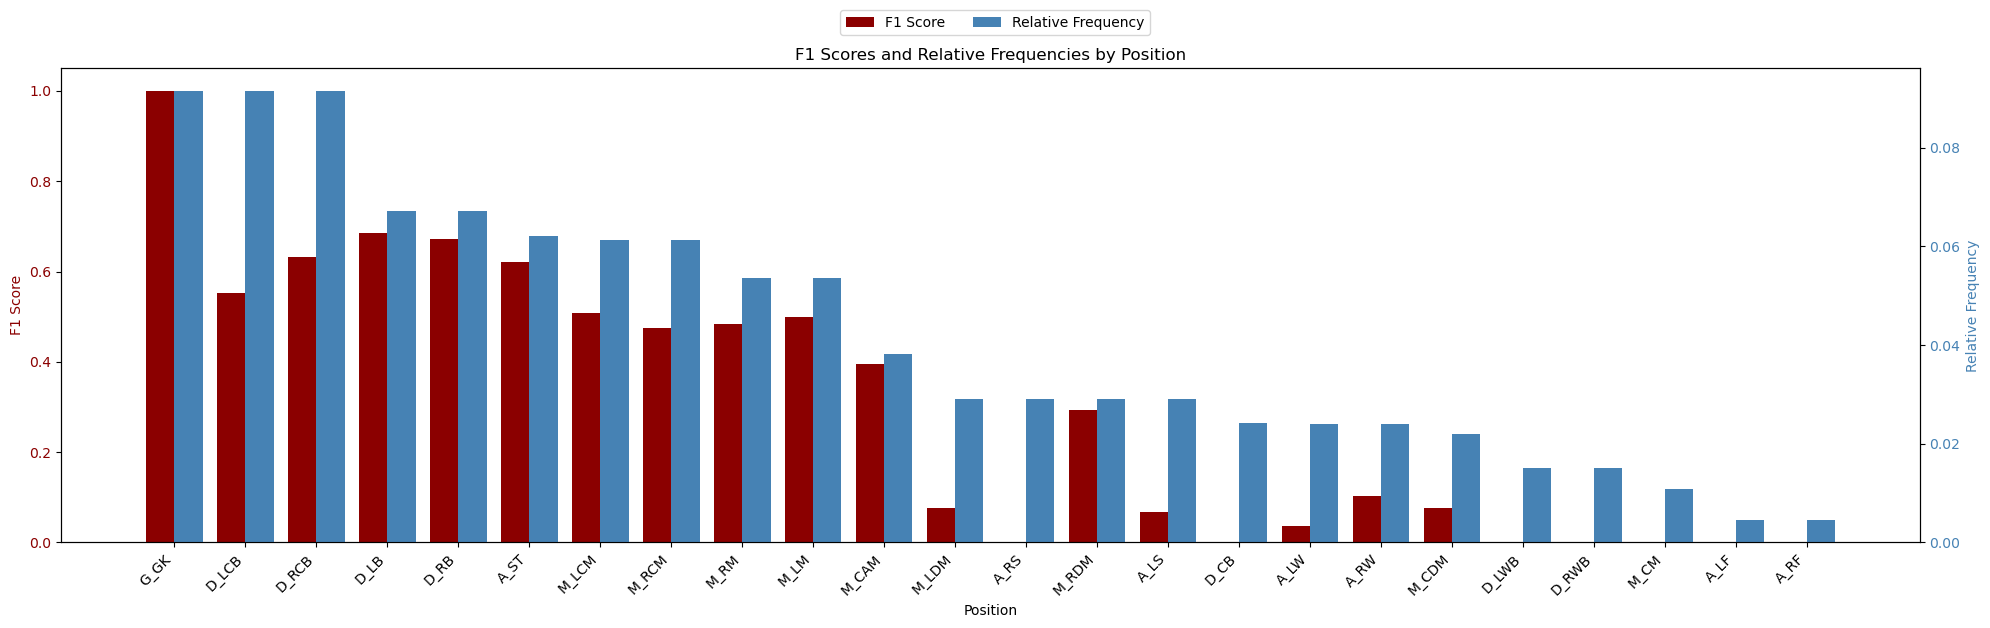

In [87]:
graph_f1_per_position(df_train = dfv1, df_report = df_report_rf)

In [68]:
best_params_rf

{'rfc__max_depth': 148,
 'rfc__max_features': 24,
 'rfc__max_leaf_nodes': 1244,
 'rfc__min_samples_leaf': 0.0013015285199047416,
 'rfc__min_samples_split': 0.010912693744184222}

In [72]:
best_scores_rf

{'f1_weighted': 0.322408894783333,
 'f1_micro': 0.3965510251434895,
 'f1_macro': 0.18772638749343232,
 'roc_auc_weighted': 0.901280182026645}

#### B. Oversampling

In [ ]:
df_report_rf_overs, best_params_rf_overs, best_scores_rf_overs = baseline_models(
    df = dfv1, numerical_features = numerical_features, categorical_features = categorical_features_all_dummies, 
    model = RandomForestClassifier, target = 'position_grouped', n_hyper_comb = 100, num_imputer = "median",
    goalkeeper_label = "G_GK", refit_score = 'f1_weighted', resampling_method = 'oversample'
    )

Fitting 5 folds for each of 100 candidates, totalling 500 fits


In [ ]:
df_report_rf_overs

,A_LF,A_LS,A_LW,A_RF,A_RS,A_RW,A_ST,D_CB,D_LB,D_LCB,...,M_CM,M_LCM,M_LDM,M_LM,M_RCM,M_RDM,M_RM,accuracy,macro avg,weighted avg
precision,0.190476,0.593939,0.423256,0.229630,0.486188,0.338870,0.705757,0.303514,0.665962,0.755853,...,0.210317,0.676471,0.470000,0.725000,0.461165,0.392226,0.618056,0.525018,0.485299,0.598919
recall,1.000000,0.487562,0.548193,0.968750,0.437811,0.614458,0.773364,0.568862,0.680346,0.358162,...,0.706667,0.054374,0.467662,0.157182,0.224586,0.552239,0.241192,0.525018,0.567221,0.525018
f1-score,0.320000,0.535519,0.477690,0.371257,0.460733,0.436831,0.738016,0.395833,0.673077,0.486022,...,0.324159,0.100656,0.468828,0.258352,0.302067,0.458678,0.346979,0.525018,0.457753,0.511420
support,32.000000,201.000000,166.000000,32.000000,201.000000,166.000000,428.000000,167.000000,463.000000,631.000000,...,75.000000,423.000000,201.000000,369.000000,423.000000,201.000000,369.000000,0.525018,6895.000000,6895.000000


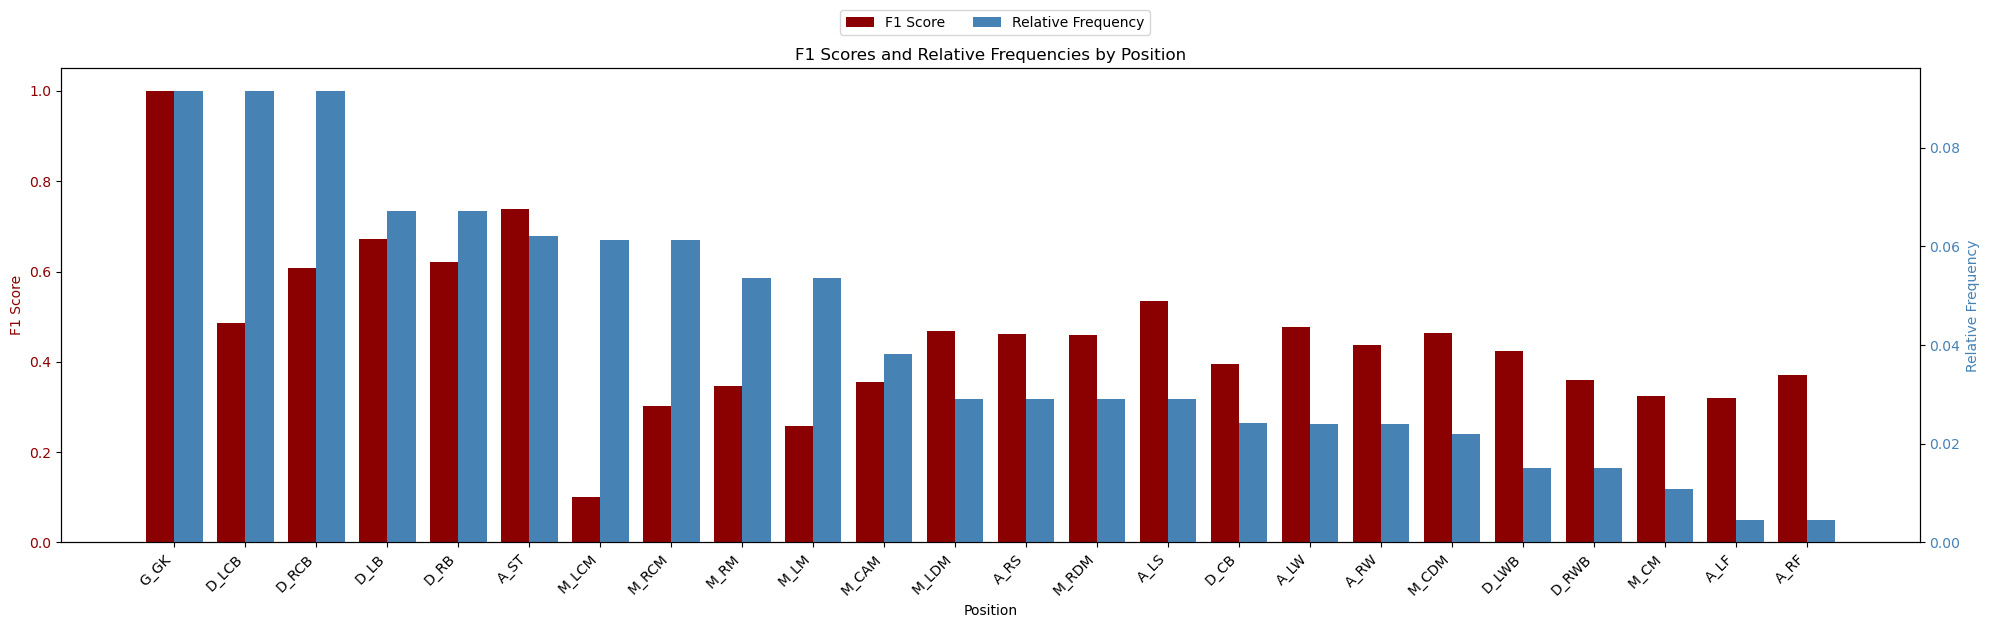

In [ ]:
graph_f1_per_position(df_train = dfv1, df_report = df_report_rf_overs)

In [ ]:
best_params_rf_overs

{'rfc__max_depth': 148,
 'rfc__max_features': 24,
 'rfc__max_leaf_nodes': 1244,
 'rfc__min_samples_leaf': 0.0013015285199047416,
 'rfc__min_samples_split': 0.010912693744184222}

In [ ]:
best_scores_rf_overs

{'f1_weighted': 0.29078672267002725,
 'f1_micro': 0.293903322122752,
 'f1_macro': 0.21790911534763846,
 'roc_auc_weighted': 0.894251696560503}

#### C. SMOTE

In [ ]:
df_report_rf_smote, best_params_rf_smote, best_scores_rf_smote = baseline_models(
    df = dfv1, numerical_features = numerical_features, categorical_features = categorical_features_all_dummies, 
    model = RandomForestClassifier, target = 'position_grouped', n_hyper_comb = 100, num_imputer = "median",
    goalkeeper_label = "G_GK", refit_score = 'f1_weighted', resampling_method = 'smote'
    )

Fitting 5 folds for each of 100 candidates, totalling 500 fits


In [ ]:
df_report_rf_smote

,A_LF,A_LS,A_LW,A_RF,A_RS,A_RW,A_ST,D_CB,D_LB,D_LCB,...,M_CM,M_LCM,M_LDM,M_LM,M_RCM,M_RDM,M_RM,accuracy,macro avg,weighted avg
precision,0.118644,0.474026,0.284615,0.139394,0.300000,0.287356,0.644028,0.317073,0.517595,0.698795,...,0.172000,0.575000,0.398438,0.685185,0.412556,0.347656,0.549020,0.478898,0.420510,0.536695
recall,0.656250,0.363184,0.445783,0.718750,0.358209,0.451807,0.642523,0.233533,0.762419,0.367670,...,0.573333,0.108747,0.253731,0.100271,0.217494,0.442786,0.151762,0.478898,0.453509,0.478898
f1-score,0.200957,0.411268,0.347418,0.233503,0.326531,0.351288,0.643275,0.268966,0.616594,0.481828,...,0.264615,0.182903,0.310030,0.174941,0.284830,0.389497,0.237792,0.478898,0.384009,0.463551
support,32.000000,201.000000,166.000000,32.000000,201.000000,166.000000,428.000000,167.000000,463.000000,631.000000,...,75.000000,423.000000,201.000000,369.000000,423.000000,201.000000,369.000000,0.478898,6895.000000,6895.000000


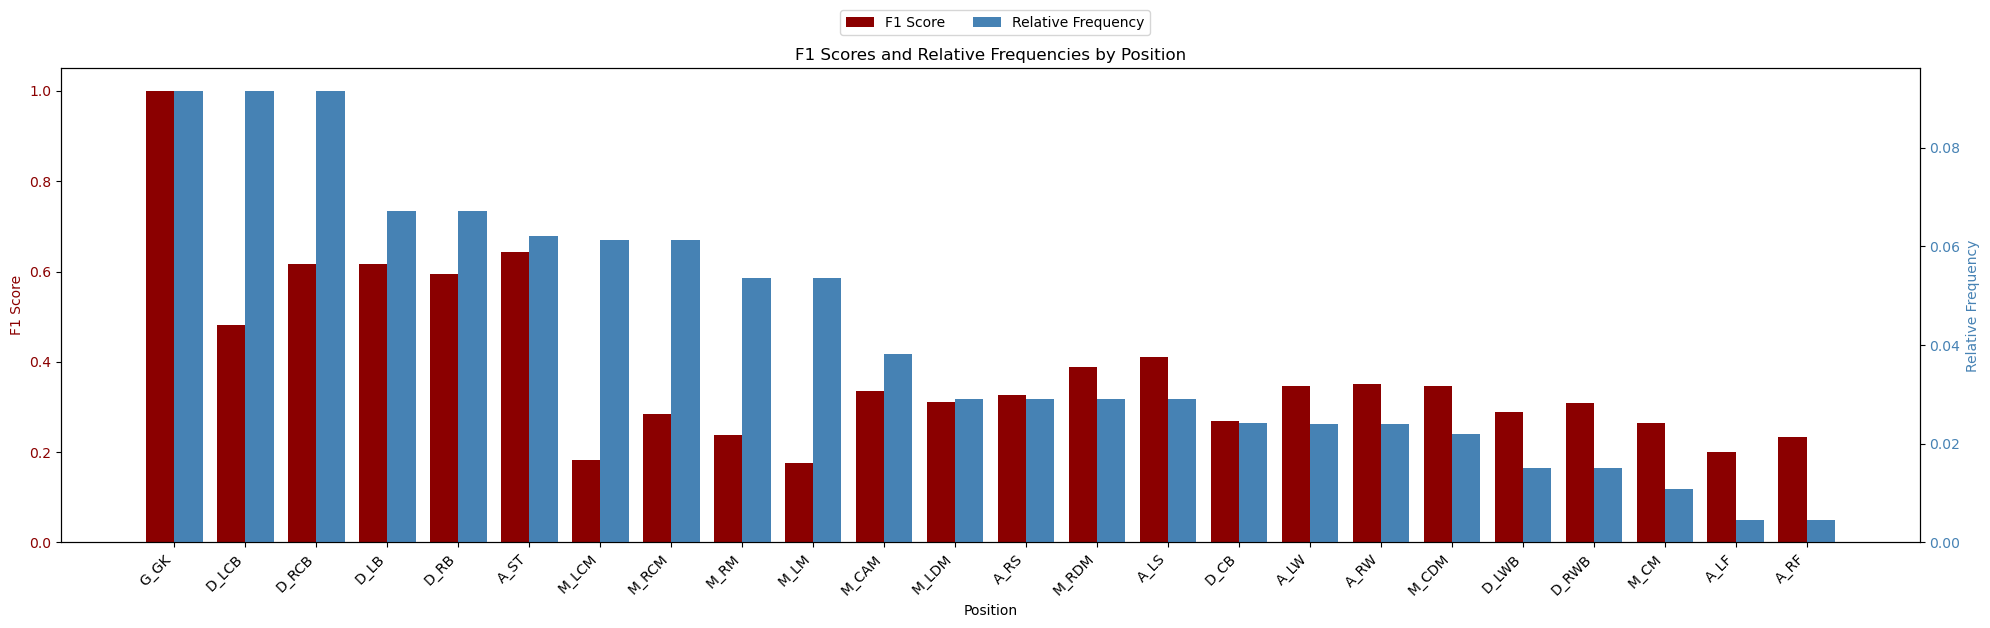

In [ ]:
graph_f1_per_position(df_train = dfv1, df_report = df_report_rf_smote)

In [ ]:
best_params_rf_smote

{'rfc__max_depth': 148,
 'rfc__max_features': 24,
 'rfc__max_leaf_nodes': 1244,
 'rfc__min_samples_leaf': 0.0013015285199047416,
 'rfc__min_samples_split': 0.010912693744184222}

In [ ]:
best_scores_rf_smote

{'f1_weighted': 0.30255549695147593,
 'f1_micro': 0.3143353077215322,
 'f1_macro': 0.2183088580720532,
 'roc_auc_weighted': 0.894173840833344}

#### D. Undersampling

In [ ]:
df_report_rf_under, best_params_rf_under, best_scores_rf_under = baseline_models(
    df = dfv1, numerical_features = numerical_features, categorical_features = categorical_features_all_dummies, 
    model = RandomForestClassifier, target = 'position_grouped', n_hyper_comb = 100, num_imputer = "median",
    goalkeeper_label = "G_GK", refit_score = 'f1_weighted', resampling_method = 'undersample'
    )

Fitting 5 folds for each of 100 candidates, totalling 500 fits


In [ ]:
df_report_rf_under

,A_LF,A_LS,A_LW,A_RF,A_RS,A_RW,A_ST,D_CB,D_LB,D_LCB,...,M_CM,M_LCM,M_LDM,M_LM,M_RCM,M_RDM,M_RM,accuracy,macro avg,weighted avg
precision,0.154472,0.265152,0.232394,0.416667,0.259259,0.193955,0.536398,0.128093,0.572874,0.737762,...,0.126374,0.264901,0.294872,0.350000,0.308333,0.253425,0.395604,0.385932,0.346306,0.459343
recall,0.593750,0.174129,0.198795,0.468750,0.278607,0.463855,0.654206,0.526946,0.611231,0.334390,...,0.306667,0.094563,0.114428,0.132791,0.174941,0.184080,0.097561,0.385932,0.371061,0.385932
f1-score,0.245161,0.210210,0.214286,0.441176,0.268585,0.273535,0.589474,0.206089,0.591432,0.460196,...,0.178988,0.139373,0.164875,0.192534,0.223228,0.213256,0.156522,0.385932,0.316926,0.389799
support,32.000000,201.000000,166.000000,32.000000,201.000000,166.000000,428.000000,167.000000,463.000000,631.000000,...,75.000000,423.000000,201.000000,369.000000,423.000000,201.000000,369.000000,0.385932,6895.000000,6895.000000


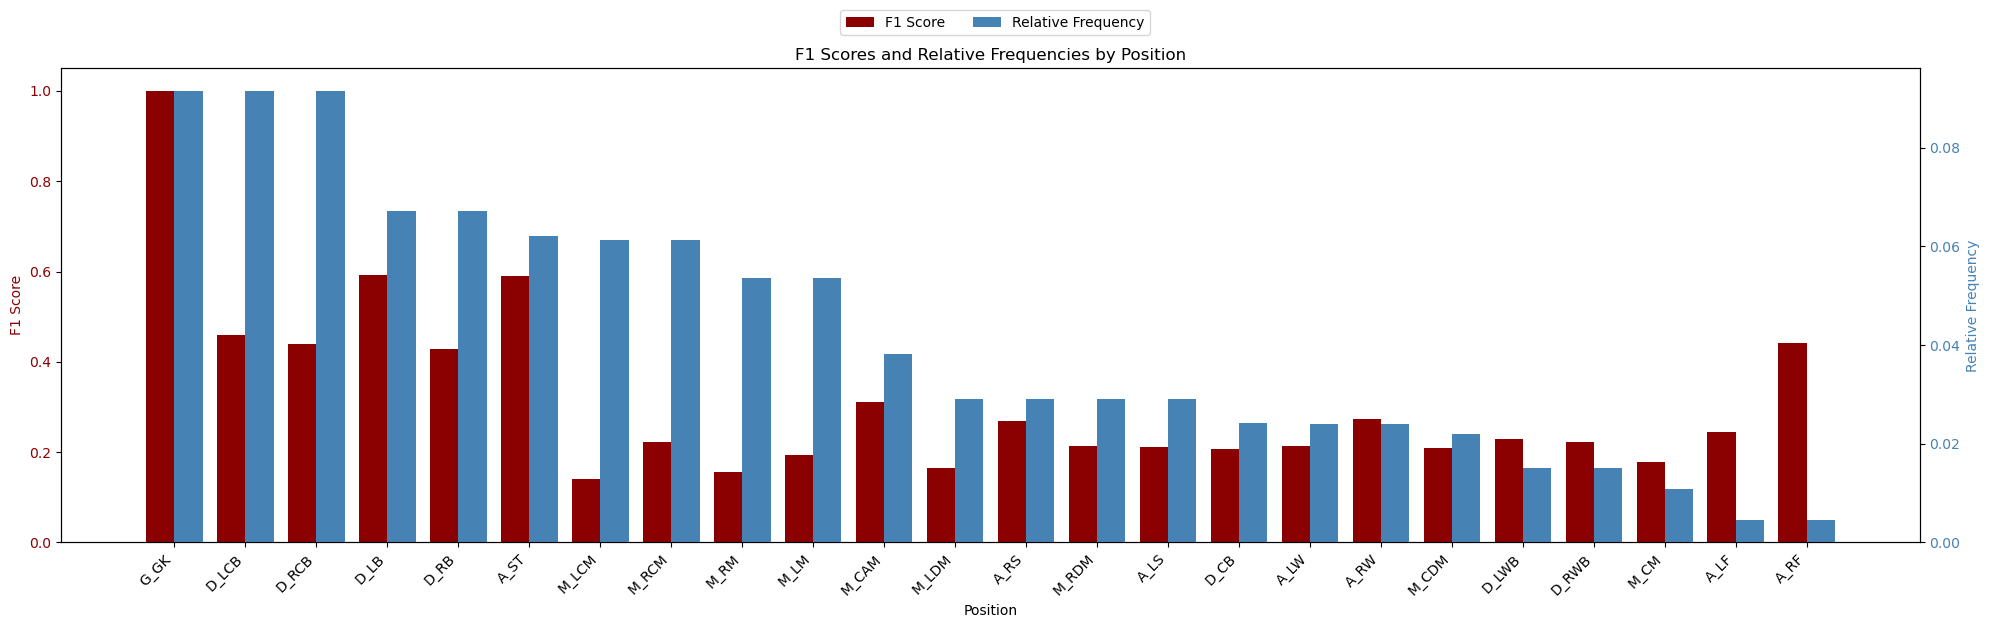

In [ ]:
graph_f1_per_position(df_train = dfv1, df_report = df_report_rf_under)

In [ ]:
best_params_rf_under

{'rfc__max_depth': 48,
 'rfc__max_features': 7,
 'rfc__max_leaf_nodes': 3096,
 'rfc__min_samples_leaf': 0.0022275055277347616,
 'rfc__min_samples_split': 0.039801263866007214}

In [ ]:
best_scores_rf_under

{'f1_weighted': 0.2653410159084525,
 'f1_micro': 0.2635702429185928,
 'f1_macro': 0.19704035152319943,
 'roc_auc_weighted': 0.8821096979259455}

#### E. Extended number of features (and oversampling)

In [ ]:
df_report_rf_overs_ext, best_params_rf_overs_ext, best_scores_rf_overs_ext = baseline_models(
    df = dfv1, numerical_features = numerical_features_ext, categorical_features = categorical_features_all_dummies_ext, 
    model = RandomForestClassifier, target = 'position_grouped', n_hyper_comb = 100, num_imputer = "median",
    goalkeeper_label = "G_GK", refit_score = 'f1_weighted', resampling_method = 'oversample'
    )

Fitting 5 folds for each of 100 candidates, totalling 500 fits


/home/pablo/miniconda3/envs/py312/lib/python3.12/site-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


In [ ]:
df_report_rf_overs_ext

,A_LF,A_LS,A_LW,A_RF,A_RS,A_RW,A_ST,D_CB,D_LB,D_LCB,...,M_CM,M_LCM,M_LDM,M_LM,M_RCM,M_RDM,M_RM,accuracy,macro avg,weighted avg
precision,0.099206,0.355556,0.240964,0.208333,0.333333,0.220141,0.520863,0.195298,0.588517,0.744755,...,0.109557,0.400000,0.350000,0.722222,0.390071,0.323529,0.535714,0.404786,0.386593,0.509728
recall,0.781250,0.159204,0.240964,0.781250,0.124378,0.566265,0.845794,0.646707,0.531317,0.337559,...,0.626667,0.009456,0.104478,0.035230,0.130024,0.273632,0.040650,0.404786,0.426483,0.404786
f1-score,0.176056,0.219931,0.240964,0.328947,0.181159,0.317032,0.644702,0.300000,0.558456,0.464558,...,0.186508,0.018476,0.160920,0.067183,0.195035,0.296496,0.075567,0.404786,0.315293,0.385174
support,32.000000,201.000000,166.000000,32.000000,201.000000,166.000000,428.000000,167.000000,463.000000,631.000000,...,75.000000,423.000000,201.000000,369.000000,423.000000,201.000000,369.000000,0.404786,6895.000000,6895.000000


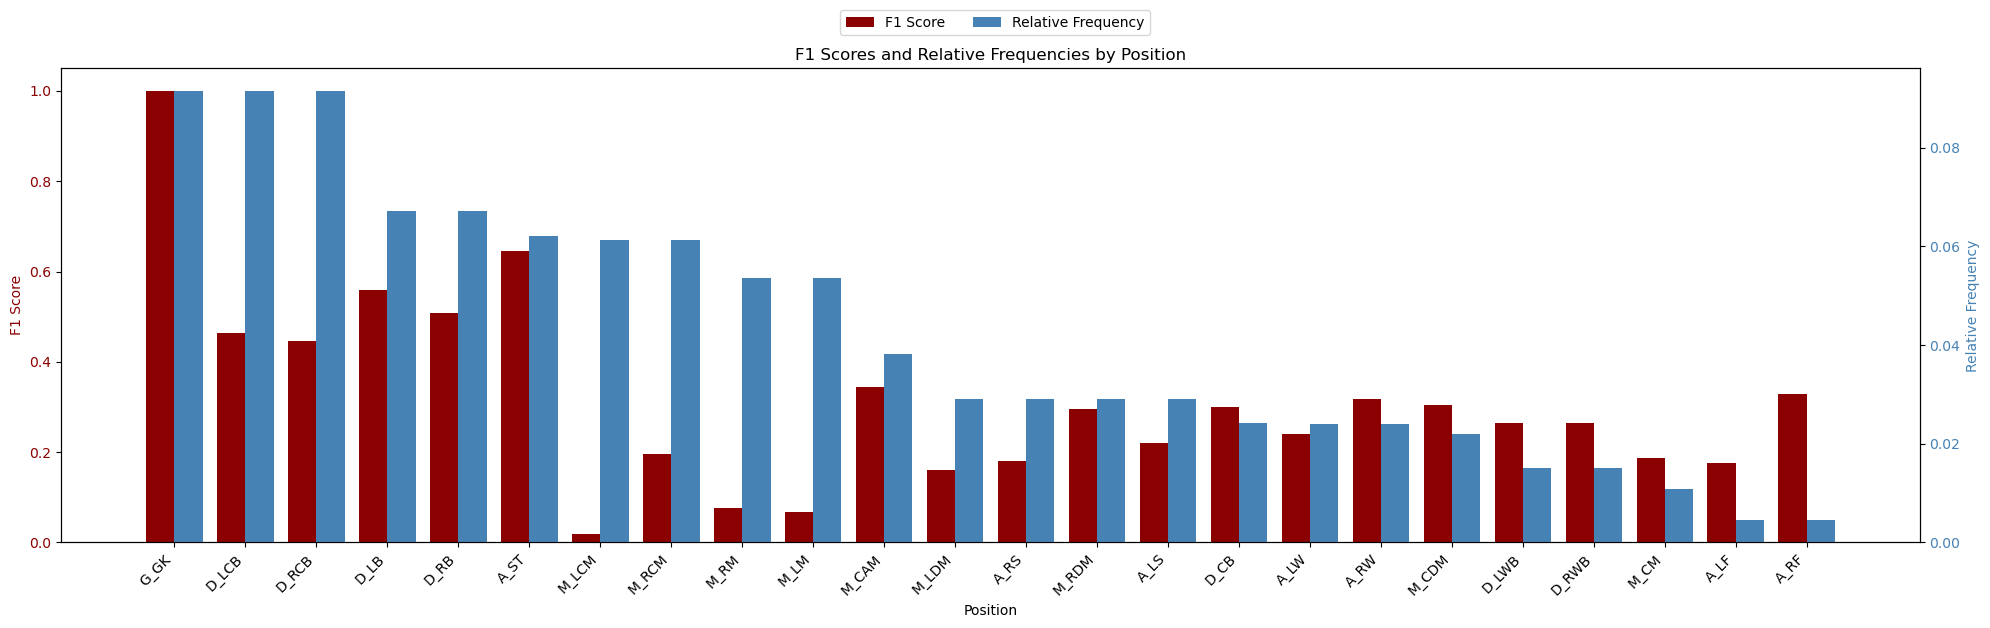

In [ ]:
graph_f1_per_position(df_train = dfv1, df_report = df_report_rf_overs_ext)

In [ ]:
best_params_rf_overs_ext

{'rfc__max_depth': 48,
 'rfc__max_features': 7,
 'rfc__max_leaf_nodes': 3096,
 'rfc__min_samples_leaf': 0.0022275055277347616,
 'rfc__min_samples_split': 0.039801263866007214}

In [ ]:
best_scores_rf_overs_ext

{'f1_weighted': 0.25863165701762825,
 'f1_micro': 0.2731472580822002,
 'f1_macro': 0.19601820708548168,
 'roc_auc_weighted': 0.8937206212368267}

#### F. No resampling, finding best F1-micro
After trying with logistic regression, it is very clear that the Kaggle competition is taking into account the F1-micro, so we should optimize for that in CV.

In [16]:
df_report_rf_2, best_params_rf_2, best_scores_rf_2 = baseline_models(
    df = dfv1, numerical_features = numerical_features, categorical_features = categorical_features_all_dummies, 
    model = RandomForestClassifier, target = 'position_grouped', n_hyper_comb = 100, num_imputer = "median",
    goalkeeper_label = "G_GK", refit_score = 'f1_micro', resampling_method = 'none'
    )

Fitting 5 folds for each of 100 candidates, totalling 500 fits


/home/pablo/miniconda3/envs/py312/lib/python3.12/site-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


In [17]:
df_report_rf_2

,A_LF,A_LS,A_LW,A_RF,A_RS,A_RW,A_ST,D_CB,D_LB,D_LCB,...,M_CM,M_LCM,M_LDM,M_LM,M_RCM,M_RDM,M_RM,accuracy,macro avg,weighted avg
precision,0.0,1.000000,0.833333,0.0,1.000000,1.000000,0.463303,0.0,0.575444,0.705584,...,0.0,0.473469,0.909091,0.455172,0.381872,0.649123,0.403738,0.542132,0.506436,0.586190
recall,0.0,0.044776,0.030120,0.0,0.004975,0.048193,0.943925,0.0,0.840173,0.440571,...,0.0,0.548463,0.049751,0.536585,0.607565,0.184080,0.585366,0.542132,0.334519,0.542132
f1-score,0.0,0.085714,0.058140,0.0,0.009901,0.091954,0.621538,0.0,0.683055,0.542439,...,0.0,0.508215,0.094340,0.492537,0.468978,0.286822,0.477876,0.542132,0.300620,0.474648
support,32.0,201.000000,166.000000,32.0,201.000000,166.000000,428.000000,167.0,463.000000,631.000000,...,75.0,423.000000,201.000000,369.000000,423.000000,201.000000,369.000000,0.542132,6895.000000,6895.000000


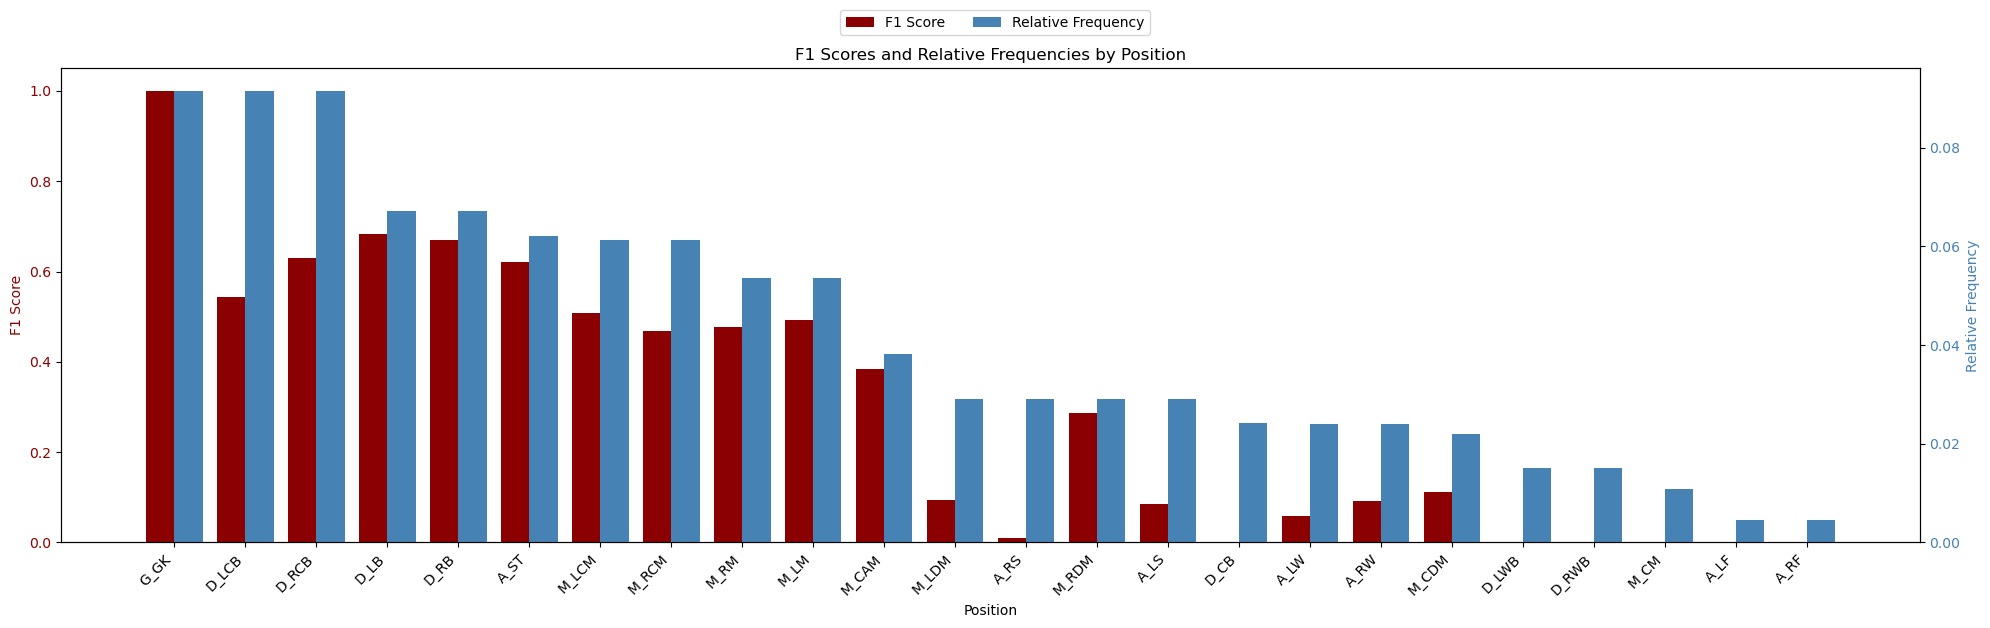

In [18]:
graph_f1_per_position(df_train = dfv1, df_report = df_report_rf_2)

In [19]:
best_params_rf_2

{'rfc__max_depth': 148,
 'rfc__max_features': 24,
 'rfc__max_leaf_nodes': 1244,
 'rfc__min_samples_leaf': 0.0013015285199047416,
 'rfc__min_samples_split': 0.010912693744184222}

In [20]:
best_scores_rf_2

{'f1_weighted': 0.32056576086984634,
 'f1_micro': 0.39495421850179374,
 'f1_macro': 0.1865762572317392,
 'roc_auc_weighted': 0.9008594105497577}

Same results as with weighted F1-score!

#### G. Oversampling, finding best F1-micro

In [25]:
df_report_rf_overs2, best_params_rf_overs2, best_scores_rf_overs2 = baseline_models(
    df = dfv1, numerical_features = numerical_features, categorical_features = categorical_features_all_dummies, 
    model = RandomForestClassifier, target = 'position_grouped', n_hyper_comb = 100, num_imputer = "median",
    goalkeeper_label = "G_GK", refit_score = 'f1_micro', resampling_method = 'oversample'
    )

Fitting 5 folds for each of 100 candidates, totalling 500 fits


/home/pablo/miniconda3/envs/py312/lib/python3.12/site-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


In [26]:
df_report_rf_overs2

,A_LF,A_LS,A_LW,A_RF,A_RS,A_RW,A_ST,D_CB,D_LB,D_LCB,...,M_CM,M_LCM,M_LDM,M_LM,M_RCM,M_RDM,M_RM,accuracy,macro avg,weighted avg
precision,0.193939,0.578035,0.426471,0.227941,0.479167,0.338558,0.704194,0.298077,0.673640,0.741100,...,0.215139,0.666667,0.482051,0.705882,0.458128,0.401408,0.609023,0.524873,0.484074,0.595244
recall,1.000000,0.497512,0.524096,0.968750,0.457711,0.650602,0.745327,0.556886,0.695464,0.362916,...,0.720000,0.052009,0.467662,0.162602,0.219858,0.567164,0.219512,0.524873,0.569125,0.524873
f1-score,0.324873,0.534759,0.470270,0.369048,0.468193,0.445361,0.724177,0.388309,0.684378,0.487234,...,0.331288,0.096491,0.474747,0.264317,0.297125,0.470103,0.322709,0.524873,0.458664,0.510429
support,32.000000,201.000000,166.000000,32.000000,201.000000,166.000000,428.000000,167.000000,463.000000,631.000000,...,75.000000,423.000000,201.000000,369.000000,423.000000,201.000000,369.000000,0.524873,6895.000000,6895.000000


In [27]:
best_params_rf_overs2

{'rfc__max_depth': 148,
 'rfc__max_features': 24,
 'rfc__max_leaf_nodes': 1244,
 'rfc__min_samples_leaf': 0.0013015285199047416,
 'rfc__min_samples_split': 0.010912693744184222}

In [28]:
best_scores_rf_overs2

{'f1_weighted': 0.2935298001147337,
 'f1_micro': 0.2967771916091476,
 'f1_macro': 0.22146317787795816,
 'roc_auc_weighted': 0.894212860757459}

#### H. Undersampling, finding best F1-micro

In [29]:
df_report_rf_under2, best_params_rf_under2, best_scores_rf_under2 = baseline_models(
    df = dfv1, numerical_features = numerical_features, categorical_features = categorical_features_all_dummies, 
    model = RandomForestClassifier, target = 'position_grouped', n_hyper_comb = 100, num_imputer = "median",
    goalkeeper_label = "G_GK", refit_score = 'f1_micro', resampling_method = 'undersample'
    )

Fitting 5 folds for each of 100 candidates, totalling 500 fits


/home/pablo/miniconda3/envs/py312/lib/python3.12/site-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


In [30]:
df_report_rf_under2

,A_LF,A_LS,A_LW,A_RF,A_RS,A_RW,A_ST,D_CB,D_LB,D_LCB,...,M_CM,M_LCM,M_LDM,M_LM,M_RCM,M_RDM,M_RM,accuracy,macro avg,weighted avg
precision,0.038462,0.083333,0.0,0.0,0.095238,0.111607,0.394033,0.111392,0.423820,0.788945,...,0.101449,0.304348,0.0,1.000000,0.200000,0.500000,0.0,0.316896,0.272107,0.402436
recall,0.187500,0.004975,0.0,0.0,0.009950,0.602410,0.894860,0.790419,0.853132,0.248811,...,0.093333,0.033097,0.0,0.002710,0.002364,0.004975,0.0,0.316896,0.252190,0.316896
f1-score,0.063830,0.009390,0.0,0.0,0.018018,0.188324,0.547143,0.195266,0.566308,0.378313,...,0.097222,0.059701,0.0,0.005405,0.004673,0.009852,0.0,0.316896,0.167962,0.257828
support,32.000000,201.000000,166.0,32.0,201.000000,166.000000,428.000000,167.000000,463.000000,631.000000,...,75.000000,423.000000,201.0,369.000000,423.000000,201.000000,369.0,0.316896,6895.000000,6895.000000


In [31]:
best_params_rf_under2

{'rfc__max_depth': 226,
 'rfc__max_features': 16,
 'rfc__max_leaf_nodes': 2933,
 'rfc__min_samples_leaf': 0.09285448044329168,
 'rfc__min_samples_split': 0.13272728160242153}

In [32]:
best_scores_rf_under2

{'f1_weighted': 0.22070148912719872,
 'f1_micro': 0.2733082773866682,
 'f1_macro': 0.14618122224801072,
 'roc_auc_weighted': 0.8668802539865439}

### GradientBoostingClassifier

#### A. No resampling, finding best F1-micro

In [ ]:
df_report_gb, best_params_gb, best_scores_gb = baseline_models(
    df = dfv1, numerical_features = numerical_features, categorical_features = categorical_features_all_dummies, 
    target = 'position_grouped', model = GradientBoostingClassifier, ada_boost = False, n_hyper_comb = 50, num_imputer = "median",
    goalkeeper_label = "G_GK", refit_score = 'f1_micro', resampling_method = 'none'
    )

Fitting 5 folds for each of 50 candidates, totalling 250 fits


With 50 hyperparameter combinations (5 folds for each of 50 candidates, totalling 250 fits), it has ran for 10 minutes approximately.

In [25]:
df_report_gb

,A_LF,A_LS,A_LW,A_RF,A_RS,A_RW,A_ST,D_CB,D_LB,D_LCB,...,M_CM,M_LCM,M_LDM,M_LM,M_RCM,M_RDM,M_RM,accuracy,macro avg,weighted avg
precision,1.000000,0.291667,0.375000,0.0,0.441860,0.484848,0.492443,0.400000,0.606688,0.646421,...,0.0,0.344891,0.481481,0.320988,0.328070,0.380000,0.354756,0.515591,0.461638,0.507670
recall,0.031250,0.034826,0.036145,0.0,0.094527,0.096386,0.913551,0.011976,0.822894,0.472266,...,0.0,0.446809,0.194030,0.422764,0.442080,0.189055,0.373984,0.515591,0.328565,0.515591
f1-score,0.060606,0.062222,0.065934,0.0,0.155738,0.160804,0.639935,0.023256,0.698442,0.545788,...,0.0,0.389289,0.276596,0.364912,0.376636,0.252492,0.364116,0.515591,0.312093,0.466777
support,32.000000,201.000000,166.000000,32.0,201.000000,166.000000,428.000000,167.000000,463.000000,631.000000,...,75.0,423.000000,201.000000,369.000000,423.000000,201.000000,369.000000,0.515591,6895.000000,6895.000000


In [28]:
best_params_gb

{'gbc__learning_rate': 0.1,
 'gbc__max_depth': 51,
 'gbc__max_features': 23,
 'gbc__max_leaf_nodes': 2141,
 'gbc__min_samples_leaf': 0.18017515564585876,
 'gbc__min_samples_split': 0.13294085911713252,
 'gbc__n_estimators': 100,
 'gbc__subsample': 0.8317908278120589}

In [27]:
best_scores_gb

{'f1_weighted': 0.33989296264867475,
 'f1_micro': 0.39655204505990743,
 'f1_macro': 0.20917857479090776,
 'roc_auc_weighted': 0.9002483819000042}

#### B. Undersampling, finding best F1-micro

In [16]:
df_report_gb_under, best_params_gb_under, best_scores_gb_under = baseline_models(
    df = dfv1, numerical_features = numerical_features, categorical_features = categorical_features_all_dummies, 
    target = 'position_grouped', model = GradientBoostingClassifier, ada_boost = False, n_hyper_comb = 50, num_imputer = "median",
    goalkeeper_label = "G_GK", refit_score = 'f1_micro', resampling_method = 'undersample'
    )

Fitting 5 folds for each of 50 candidates, totalling 250 fits


In [17]:
df_report_gb_under

,A_LF,A_LS,A_LW,A_RF,A_RS,A_RW,A_ST,D_CB,D_LB,D_LCB,...,M_CM,M_LCM,M_LDM,M_LM,M_RCM,M_RDM,M_RM,accuracy,macro avg,weighted avg
precision,0.141553,0.244526,0.239362,0.156977,0.276995,0.223529,0.569231,0.188462,0.638710,0.535354,...,0.153005,0.297071,0.226562,0.348387,0.389908,0.215859,0.394737,0.392748,0.343743,0.460057
recall,0.968750,0.333333,0.271084,0.843750,0.293532,0.343373,0.432243,0.586826,0.427646,0.335975,...,0.373333,0.167849,0.288557,0.146341,0.200946,0.243781,0.162602,0.392748,0.414324,0.392748
f1-score,0.247012,0.282105,0.254237,0.264706,0.285024,0.270784,0.491368,0.285298,0.512290,0.412853,...,0.217054,0.214502,0.253829,0.206107,0.265211,0.228972,0.230326,0.392748,0.331116,0.402960
support,32.000000,201.000000,166.000000,32.000000,201.000000,166.000000,428.000000,167.000000,463.000000,631.000000,...,75.000000,423.000000,201.000000,369.000000,423.000000,201.000000,369.000000,0.392748,6895.000000,6895.000000


In [18]:
best_params_gb_under

{'gbc__learning_rate': 0.1,
 'gbc__max_depth': 260,
 'gbc__max_features': 5,
 'gbc__max_leaf_nodes': 1637,
 'gbc__min_samples_leaf': 0.11169777079159572,
 'gbc__min_samples_split': 0.15299634556560604,
 'gbc__n_estimators': 100,
 'gbc__subsample': 0.7736811730666274}

In [19]:
best_scores_gb_under

{'f1_weighted': 0.276352428514128,
 'f1_micro': 0.25829969733980296,
 'f1_macro': 0.20813109089947185,
 'roc_auc_weighted': 0.8627701365664256}

#### C. Oversampling, finding best F1-micro

In [21]:
df_report_gb_over, best_params_gb_over, best_scores_gb_over = baseline_models(
    df = dfv1, numerical_features = numerical_features, categorical_features = categorical_features_all_dummies, 
    target = 'position_grouped', model = GradientBoostingClassifier, ada_boost = False, n_hyper_comb = 50, num_imputer = "median",
    goalkeeper_label = "G_GK", refit_score = 'f1_micro', resampling_method = 'oversample'
    )

Fitting 5 folds for each of 50 candidates, totalling 250 fits


In [22]:
df_report_gb_over

,A_LF,A_LS,A_LW,A_RF,A_RS,A_RW,A_ST,D_CB,D_LB,D_LCB,...,M_CM,M_LCM,M_LDM,M_LM,M_RCM,M_RDM,M_RM,accuracy,macro avg,weighted avg
precision,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.982036,1.0,0.990244,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.995504,0.997428,0.995560
recall,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.982036,1.0,0.965135,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.995504,0.997403,0.995504
f1-score,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.982036,1.0,0.977528,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.995504,0.997402,0.995503
support,32.0,201.0,166.0,32.0,201.0,166.0,428.0,167.000000,463.0,631.000000,...,75.0,423.0,201.0,369.0,423.0,201.0,369.0,0.995504,6895.000000,6895.000000


In [23]:
best_params_gb_over

{'gbc__learning_rate': 0.1,
 'gbc__max_depth': 235,
 'gbc__max_features': 8,
 'gbc__max_leaf_nodes': 2622,
 'gbc__min_samples_leaf': 0.027275110625239626,
 'gbc__min_samples_split': 0.10632325151540195,
 'gbc__n_estimators': 500,
 'gbc__subsample': 0.9874254426586675}

In [24]:
best_scores_gb_over

{'f1_weighted': 0.34160106839201104,
 'f1_micro': 0.3647850908618039,
 'f1_macro': 0.22927187254684872,
 'roc_auc_weighted': 0.8874408899954128}

### LGBMClassifier

#### A. No resampling, finding best F1-micro

In [12]:
df_report_lgb, best_params_lgb, best_scores_lgb = baseline_models(
    df = dfv1, numerical_features = numerical_features, categorical_features = categorical_features_all_dummies, 
    target = 'position_grouped', model = LGBMClassifier, ada_boost = False, n_hyper_comb = 50, num_imputer = "median",
    goalkeeper_label = "G_GK", refit_score = 'f1_micro', resampling_method = 'none'
    )

Fitting 5 folds for each of 50 candidates, totalling 250 fits


It has been running for 30 mins for 50 hyperparameter combinations (50 iterations).

In [13]:
df_report_lgb

,A_LF,A_LS,A_LW,A_RF,A_RS,A_RW,A_ST,D_CB,D_LB,D_LCB,...,M_CM,M_LCM,M_LDM,M_LM,M_RCM,M_RDM,M_RM,accuracy,macro avg,weighted avg
precision,1.000000,0.970588,0.939394,1.00000,0.937500,0.963636,0.633181,1.000000,0.687606,0.757282,...,1.000000,0.672165,0.926471,0.716667,0.647303,0.856164,0.702128,0.73256,0.844734,0.775996
recall,0.437500,0.492537,0.560241,0.15625,0.522388,0.638554,0.971963,0.131737,0.874730,0.618067,...,0.386667,0.770686,0.626866,0.699187,0.737589,0.621891,0.715447,0.73256,0.611454,0.732560
f1-score,0.608696,0.653465,0.701887,0.27027,0.670927,0.768116,0.766820,0.232804,0.769962,0.680628,...,0.557692,0.718062,0.747774,0.707819,0.689503,0.720461,0.708725,0.73256,0.657958,0.720678
support,32.000000,201.000000,166.000000,32.00000,201.000000,166.000000,428.000000,167.000000,463.000000,631.000000,...,75.000000,423.000000,201.000000,369.000000,423.000000,201.000000,369.000000,0.73256,6895.000000,6895.000000


In [14]:
best_params_lgb

{'lgb__boosting_type': 'gbdt',
 'lgb__feature_fraction': 0.7156590973427577,
 'lgb__learning_rate': 0.01,
 'lgb__min_child_samples': 26,
 'lgb__min_split_gain': 0.00019381680792066592,
 'lgb__num_leaves': 31,
 'lgb__reg_lambda': 0.8494364888772069}

In [15]:
best_scores_lgb

{'f1_weighted': 0.3397435778373765,
 'f1_micro': 0.3975088541494024,
 'f1_macro': 0.20877405965375648,
 'roc_auc_weighted': 0.8962785630827919}

### Insights
- Overall, *logistic regression* is the best performer in this case, while a single decision tree and KNN exhibit a similar predictive power.
- Best results:
    1. Logistic regression with no resampling.
    2. Gradient boosting with no resampling.
    3. LightGBM with no resampling.
    4. Decision trees with adaptive boosting and no resampling.
    5. Random forest with no resampling.